# cell 1

In [2]:
# === Cell 1 — Imports, paths, toggles ===
from pathlib import Path
import re
import numpy as np, pandas as pd, tifffile, matplotlib.pyplot as plt
from skimage import measure, segmentation
from skimage.morphology import opening, remove_small_objects, disk
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist
from scipy import ndimage as ndi            # ← לדילציה/מרחקים
from tqdm.auto import tqdm
import imageio.v3 as iio

# ---- בסיס קבצים ----
ROOT_DIR   = Path.cwd()
DATA_DIR   = ROOT_DIR / "DATA"

# ---- בחירת מקור הסגמנטציה ----
# 'png'  → טוען מתיקייה של קבצי PNG רבים
# 'tif'  → טוען מערימת TIF (ערוץ seg) ללא מחלקות (בינרי) או עם ערוצים
SEG_SOURCE     = 'tif'           # 'png' | 'tif'

# ---- הגדרות קלט ל-PNG ----
PNG_DIR        = DATA_DIR / "frame_020"     # תיקייה המכילה את הפריימים
PNG_GLOB       = "frame_*.png"              # תבנית חיפוש
PNG_VALUE_MAP  = {0:0, 85:1, 170:2, 255:3}  # ערכי פיקסל → מחלקות
VALID_CELL_CLASSES = {1, 2}                 # מה נחשב "תא" (למסיכה הבינרית)

# ---- הגדרות קלט ל-TIF ----
STACK_TIF_SEG  = DATA_DIR / "position4_seg.tif"  # seg: ערוץ 1 (או (T,H,W))
# כמה פריימים להפעיל עליהם את המעקב.
# None או מספר גדול/שווה לאורך הווידאו => לא לחתוך (לעבוד על כל הווידאו)
TRACK_FIRST_N = 100  # למשל: 500

STAGE_PKL   = DATA_DIR / "stage_locations_position4.pkl"

# דילציה ליצירת "טבעת גבול" (class=0) סביב תאים כשמקור TIF בינרי:
ADD_CLASS3_DILATE_ITERS = 1   # 0=ללא טבעת; 1=טבעת דקה (מומלץ)

# ---- מגבלת פריימים (לא חובה) ----
N_FRAMES_LIMIT = None         # None=כל המשותף; או למשל 21

print(f"Ready. SEG_SOURCE={SEG_SOURCE} | N_FRAMES_LIMIT={N_FRAMES_LIMIT}")

# ==== params (נשמרו אחד-לאחד) ====
PIX_MIN    = 50      # מינימום שטח תא בפיקסלים
R_OPEN     = 0       # opening radius למריחה קלה (שומר על מהירות)
ALPHA_DIST = 0.6 #0.9     # משקל מרחק בקוסט המעקב
R0_PIX     = 44      # קוטר תא ממוצע (px) לנרמול המרחק
COST_THR   = 0.85 #0.75    # סף קבלה להתאמה (נמוך יותר = יותר חיבורים)
R_GATE     = 40      # שער מרחק: התאמות רחוקות מזה ייחסמו
DOT_RAD    = 12      # רדיוס הנקודה (px) להצגה


Ready. SEG_SOURCE=tif | N_FRAMES_LIMIT=None


# cell 2

In [4]:
# === Cell 2 — Unified loader (GT + SEG) + synth class-3 for TIF ===

def natural_key(p: Path):
    """מפתח מיון נומרי לשמות קבצים כמו frame_000.png → [ 'frame_', 0, '.png' ]"""
    return [int(s) if s.isdigit() else s for s in re.split(r'(\d+)', p.name)]


# --- SEG: שני מצבים — PNG או TIF ---
if SEG_SOURCE.lower() == 'png':
    files = sorted(PNG_DIR.glob(PNG_GLOB), key=natural_key)
    if not files:
        raise FileNotFoundError(f"No PNG files matching {PNG_GLOB} in {PNG_DIR}")

    # LUT מהיר 0..255 → {-1,0,1,2,3}
    lut = np.full(256, -1, dtype=np.int16)
    for k, v in PNG_VALUE_MAP.items():
        lut[int(k)] = int(v)

    seg_list_cls = []
    unknown_vals = set()

    for p in files:
        img = iio.imread(p)
        if img.ndim == 3:
            img = img[..., 0]
        if img.dtype != np.uint8:
            mx = float(img.max()) or 1.0
            img = (img.astype(np.float32)/mx*255.0 + 0.5).astype(np.uint8)
        lab_cls = lut[img]  # -1 אם ערך לא ממופה
        bad = np.unique(img[lab_cls == -1])
        if bad.size:
            unknown_vals.update(map(int, bad))
            lab = lab_cls.copy()
            lab[lab_cls == -1] = 0      # ממפים לא מוכר לרקע 0 (שמרני)
            lab_cls = lab
        seg_list_cls.append(lab_cls.astype(np.int32))

    seg_full_cls = np.stack(seg_list_cls, axis=0)        # (N,H,W) עם 0/1/2/3
    # --- Apply frame limit ASAP (before any per-frame work) ---
    T_total = int(seg_full_cls.shape[0])
    N1 = TRACK_FIRST_N if isinstance(TRACK_FIRST_N, int) and TRACK_FIRST_N > 0 else T_total
    N2 = N_FRAMES_LIMIT if isinstance(N_FRAMES_LIMIT, int) and N_FRAMES_LIMIT > 0 else T_total
    N  = min(T_total, N1, N2)

    if N < T_total:
        print(f"[limit] using first {N}/{T_total} frames (TRACK_FIRST_N / N_FRAMES_LIMIT)")
    seg_full_cls = seg_full_cls[:N]

    seg_full     = np.isin(seg_full_cls, list(VALID_CELL_CLASSES)).astype(np.uint8)

    print(f"Loaded PNGs → seg_full_cls={seg_full_cls.shape} (values={sorted(np.unique(seg_full_cls).tolist())})")
    if unknown_vals:
        print("[WARN] unmapped PNG values coerced to 0:", sorted(unknown_vals))

elif SEG_SOURCE.lower() == 'tif':
    # --- נחליט מראש כמה פריימים לקרוא (N) ---
    with tifffile.TiffFile(STACK_TIF_SEG) as tf:
        s = tf.series[0]
        axes = getattr(s, "axes", "")
        shape = s.shape
        # גודל T:
        T_total = shape[axes.index('T')] if ('T' in axes) else shape[0]
    # חישוב N מהטוגלים שלך:
    cap1 = TRACK_FIRST_N if isinstance(TRACK_FIRST_N, int) and TRACK_FIRST_N > 0 else T_total
    cap2 = N_FRAMES_LIMIT if isinstance(N_FRAMES_LIMIT, int) and N_FRAMES_LIMIT > 0 else T_total
    N = min(T_total, cap1, cap2)

    print(f"[TIF] axes={axes} shape={shape} → T_total={T_total}  |  using first N={N}")

    # --- קריאה חלקית מהדיסק בלבד ---
    # מקרה נפוץ: מחסנית 3D (T,H,W) → פשוט:
    # (tifffile קורא רק את הדפים שביקשנו)
    stack_head = tifffile.imread(STACK_TIF_SEG, key=range(N))

    # ממפים ל-seg_raw בהתאם לצורה שנקראה:
    if stack_head.ndim == 3:
        # (N,H,W)
        seg_raw = stack_head

    elif stack_head.ndim == 4:
        # לפעמים קורה שחוזר (N,C,H,W). נבחר את ערוץ הסגמנטציה (בד"כ 1).
        c_idx = 1 if stack_head.shape[1] >= 2 else 0
        seg_raw = stack_head[:, c_idx]

    else:
        # אם יוצאת צורה לא צפויה (למשל עמודים שטוחים), נשתמש בפולבאק פשוט:
        # קוראים N*C דפים ראשונים ומוציאים רק את הערוץ הרצוי בצעדי C.
        with tifffile.TiffFile(STACK_TIF_SEG) as tf:
            s = tf.series[0]
            axes = getattr(s, "axes", "")
            shape = s.shape
            C = shape[axes.index('C')] if ('C' in axes) else 1
        pages = tifffile.imread(STACK_TIF_SEG, key=range(min(N*max(C,1), T_total*max(C,1))))
        if pages.ndim == 3 and C > 1:
            seg_raw = pages[1::C][:N]  # לוקח כל C-דף, מתחיל בערוץ 1
        else:
            seg_raw = pages[:N]

    # --- מכאן ההמשך זהה לקוד שלך (נירמול מחלקות וכו') ---
    seg_raw = seg_raw.astype(np.int32, copy=False)

    uniq = np.unique(seg_raw)
    if np.all(np.isin(uniq, [0, 1, 2, 3])):
        seg_full_cls = seg_raw.astype(np.uint8, copy=False)
    elif np.all(np.isin(uniq, [0, 85, 170, 255])):
        lut = np.full(256, 0, dtype=np.uint8)
        lut[0]   = 0
        lut[85]  = 1
        lut[170] = 2
        lut[255] = 3
        seg_full_cls = lut[seg_raw.astype(np.uint8)]
    elif uniq.size == 2 and 0 in uniq:
        seg_full_cls = np.where(seg_raw > 0, 2, 0).astype(np.uint8)
    else:
        umin, umax = uniq.min(), uniq.max()
        if 0 <= umin and umax <= 3:
            seg_full_cls = np.rint(seg_raw).astype(np.uint8)
        else:
            seg_full_cls = np.where(seg_raw > 0, 2, 0).astype(np.uint8)
            print("[WARN] Unknown class codes in TIF; fell back to binary→{0,2}.")

    # הוספת class-3 רחוק (כמו שהיה)
    from scipy import ndimage as ndi
    ADD_CLASS3_DILATE_ITERS = int(globals().get('ADD_CLASS3_DILATE_ITERS', 1))

    def add_class3_from_tif(frame_uint8: np.ndarray, dilate_iters: int = 1) -> np.ndarray:
        out = frame_uint8.astype(np.uint8, copy=True)
        cell_mask = (out == 1) | (out == 2)
        zero_mask = (out == 0)
        near = ndi.binary_dilation(cell_mask, iterations=int(dilate_iters)) if dilate_iters > 0 else cell_mask
        out[zero_mask & (~near)] = 3
        return out

    for t in range(seg_full_cls.shape[0]):  # ← כבר N פריימים בלבד
        seg_full_cls[t] = add_class3_from_tif(seg_full_cls[t], ADD_CLASS3_DILATE_ITERS)

    seg_full = np.isin(seg_full_cls, [1, 2]).astype(np.uint8)

    T, H, W = seg_full.shape
    print(f"Using N_FRAMES={T}  |  SEG={seg_full.shape}")


[TIF] axes=TCYX shape=(273, 2, 1932, 1932) → T_total=273  |  using first N=100
[WARN] Unknown class codes in TIF; fell back to binary→{0,2}.
Using N_FRAMES=100  |  SEG=(100, 1932, 1932)


# Cell 2B — Boundary carving from PNG classes

seg_full updated with boundary carving. unique before: [0, 1] | unique after: [0, 1] | BOUND_THICKEN = 1


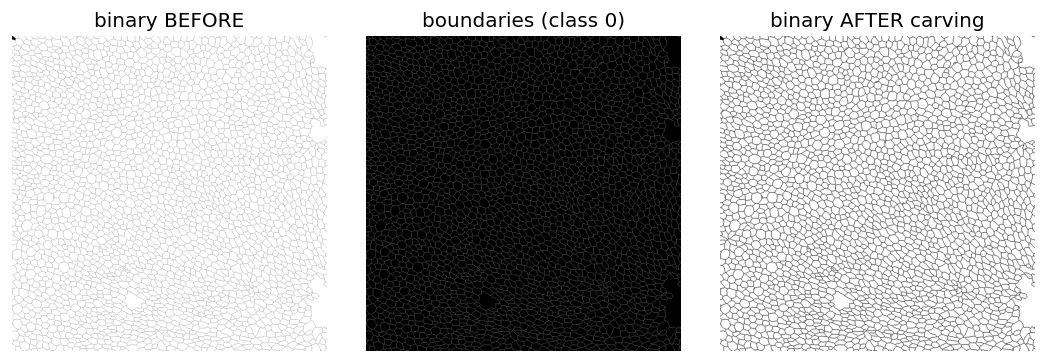

In [6]:
# === Cell 2B — Boundary carving from classes (PNG/TIF compatible) ===
# מסיר "קווי גבול" (class=0) מהמסכת תאים כדי למנוע איחודים — עם שליטה בעובי.

from skimage.morphology import binary_dilation, disk

# טוגלים/פרמטרים:
# אם מקור TIF ואתה כבר יוצר טבעת 0 באמצעות ADD_CLASS3_DILATE_ITERS, אפשר להתחיל מ-0–1.
BOUND_THICKEN = 1 if SEG_SOURCE.lower() == 'tif' else 2   # מומלץ: TIF→1, PNG→2

# מסכות עזר מתוך seg_full_cls:
cells_mask   = np.isin(seg_full_cls, [1, 2])   # hair+support (ב-TIF לרוב רק 2)
boundary_msk = (seg_full_cls == 0)             # "גבול"

# עיבוי גבול (לפי הצורך)
if BOUND_THICKEN > 0:
    fp = disk(int(BOUND_THICKEN))
    barriers = np.empty_like(boundary_msk, dtype=bool)
    for t in range(T):
        barriers[t] = binary_dilation(boundary_msk[t], footprint=fp)
else:
    barriers = boundary_msk.copy()

# קרבינג בפועל: תאים פחות המחסומים
seg_full_before = seg_full.copy()
seg_full = (cells_mask & (~barriers)).astype(np.uint8)

print("seg_full updated with boundary carving.",
      "unique before:", np.unique(seg_full_before).tolist(),
      "| unique after:", np.unique(seg_full).tolist(),
      "| BOUND_THICKEN =", BOUND_THICKEN)

# ויזואליזציה להשוואה
k = 0
plt.figure(figsize=(9,3), dpi=120)
plt.subplot(1,3,1); plt.imshow(seg_full_before[k] > 0, cmap='gray'); plt.title("binary BEFORE"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(boundary_msk[k], cmap='gray');       plt.title("boundaries (class 0)"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(seg_full[k] > 0, cmap='gray');        plt.title("binary AFTER carving"); plt.axis('off')
plt.tight_layout()


# cell 3

96 good  |  4 bad


(-0.5, 1931.5, 1931.5, -0.5)

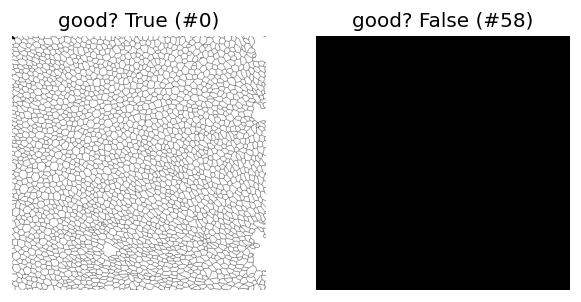

In [8]:
def is_good_frame(mask):
    return np.count_nonzero(mask) > 1000

good_idx = [i for i in range(T) if is_good_frame(seg_full[i] > 0)]
bad_idx  = [i for i in range(T) if i not in good_idx]
print(f"{len(good_idx)} good  |  {len(bad_idx)} bad")

# הצגה מהירה
g = (good_idx[:1] or [0])[0]
b = (bad_idx[:1]  or [g])[0]
plt.figure(figsize=(6,3), dpi=120)
plt.subplot(1,2,1); plt.imshow(seg_full[g] > 0, cmap='gray'); plt.title(f"good? {g in good_idx} (#{g})"); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(seg_full[b] > 0, cmap='gray'); plt.title(f"good? {b in good_idx} (#{b})"); plt.axis('off')


# cell 4

⚠️ STAGE PKL not found — using image-based drift only.
drift steps: stage=0 | image=95 | MAX_STEP=250.0
good→good final-step px: p50=0.00  p90=11.52  p95=18.21
examples of large/image-resolved steps:


,prev,cur,dr_stage,dc_stage,mag_stage,dr_img,dc_img,mag_img,used,dr_final,dc_final,mag_final,capped
0,0,1,0.0,0.0,0.0,0.0,0.0,0.000000,img,0.0,0.0,0.000000,False
1,1,2,0.0,0.0,0.0,-20.0,0.0,20.000000,img,-20.0,0.0,20.000000,False
2,2,3,0.0,0.0,0.0,0.0,0.0,0.000000,img,0.0,0.0,0.000000,False
3,3,4,0.0,0.0,0.0,-18.0,2.0,18.110770,img,-18.0,2.0,18.110770,False
4,4,5,0.0,0.0,0.0,0.0,0.0,0.000000,img,0.0,0.0,0.000000,False
5,5,6,0.0,0.0,0.0,-18.0,4.0,18.439089,img,-18.0,4.0,18.439089,False
6,6,7,0.0,0.0,0.0,0.0,0.0,0.000000,img,0.0,0.0,0.000000,False
7,7,8,0.0,0.0,0.0,-14.0,4.0,14.560220,img,-14.0,4.0,14.560220,False
8,8,9,0.0,0.0,0.0,0.0,0.0,0.000000,img,0.0,0.0,0.000000,False
9,9,10,0.0,0.0,0.0,-12.0,4.0,12.649111,img,-12.0,4.0,12.649111,False


wrote /Users/idanaviv/Downloads/final_project/implementation/DATA/drift_steps_debug.csv
padding (r,c): top=1236, bottom=1000, left=1000, right=1154


Applying drift (stage+image):   0%|          | 0/100 [00:00<?, ?it/s]

ROI (wide) box: rows[0:4168] cols[0:4086] → size 4168x4086 (out of 4168x4086)
Drift applied (stage+image + padding). seg_work shape: (100, 4168, 4086)


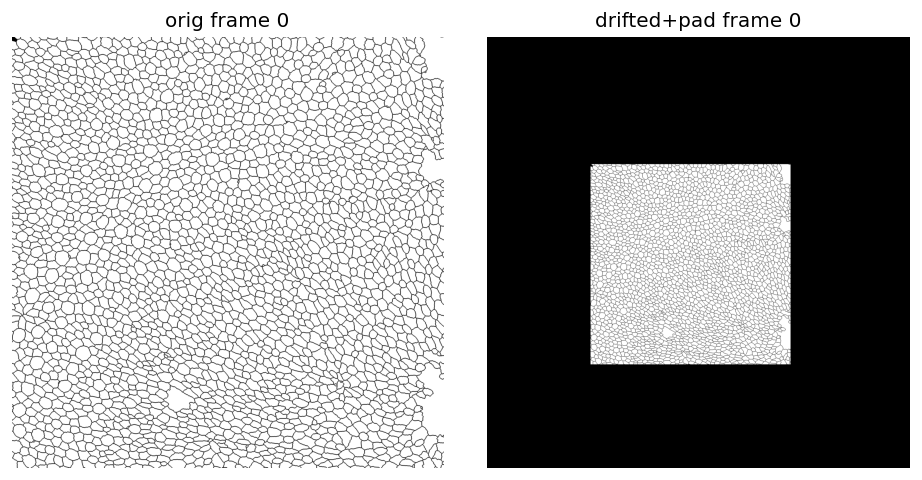

In [10]:
# === Cell 4 — Drift with stage + image fallback, padding & ROI (robust) ===
from pathlib import Path
from scipy.ndimage import shift as nd_shift
from skimage.registration import phase_cross_correlation
import pickle, numpy as np, matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm

APPLY_DRIFT = True
PIX_UM      = 0.099

# ← עדכן כאן לפי הצורך
MAX_STEP   = 250.0   # cap לצעד בין good→good (בפיקסלים). אפשר 650 כדי לכסות גם ~582px
PAD_FACTOR = 4       # ריפוד נוסף יחסית ל-MAX_STEP

# פרמטרים ל-fallback מהתמונה
JUMP_MIN          = 25.0   # סף "קפיצה גדולה" שמאותת להשתמש ב-image-based drift
STAGE_SMALL_FRAC  = 0.6    # אם mag_stage < 0.6*JUMP_MIN ואילו mag_img >= JUMP_MIN → נעדיף image
PC_DS             = 2      # downsample×2 לחישוב phase-correlation מהיר

# --- שליטה על ROI: 0.0 = יוניון (כל פיקסל שהיה תקף באחד הפריימים), 1.0 = חיתוך מלא (AND)
ROI_MIN_FRAC = 0.0

# נשמור גם את גודל המקור לצורך "חזרה ל-1932x1932" בהמשך
ORIG_H, ORIG_W = int(seg_full.shape[1]), int(seg_full.shape[2])

def pc_shift_rows_cols(imgA, imgB, ds=2):
    """Phase-correlation על מסכות (seg>0). מחזיר (dr, dc, mag) בפיקסלים."""
    A = (imgA > 0)[::ds, ::ds].astype(float)
    B = (imgB > 0)[::ds, ::ds].astype(float)
    sh, _, _ = phase_cross_correlation(A, B, upsample_factor=1)
    dr = float(sh[0] * ds)  # rows (y)
    dc = float(sh[1] * ds)  # cols (x)
    return dr, dc, float(np.hypot(dr, dc))

if not APPLY_DRIFT:
    seg_work = seg_full.copy()
    valid_roi = np.ones_like(seg_work[0], dtype=bool)
    pad_top = pad_bottom = pad_left = pad_right = 0
    shifts_rc = np.zeros((T,2), dtype=float)
    print("Drift OFF. seg_work shape:", seg_work.shape)

else:
    # ---- stage (אם יש) — הגנה מפני קובץ חסר/קצר ----
    stage_exists = ('STAGE_PKL' in globals()) and Path(STAGE_PKL).exists()
    if stage_exists:
        stage = pickle.load(open(STAGE_PKL, "rb"))
        x_um = np.asarray(stage['x'], float)
        y_um = np.asarray(stage['y'], float)
        STAGE_T = int(min(len(x_um), len(y_um)))
        # נחתוך/נרפד כדי לא לחרוג באינדקסים
        if STAGE_T < T:
            # ריפוד בקצה ב-edge — “מחזיק ערך אחרון”
            pad = T - STAGE_T
            x_um = np.pad(x_um, (0, pad), mode='edge')
            y_um = np.pad(y_um, (0, pad), mode='edge')
            STAGE_T = T
        else:
            x_um = x_um[:T]; y_um = y_um[:T]; STAGE_T = T
        print(f"stage loaded: len={STAGE_T} (clamped/padded to T={T})")
    else:
        print("⚠️ STAGE PKL not found — using image-based drift only.")
        STAGE_T = 0

    good_sorted = np.array(sorted(good_idx), dtype=int)
    if len(good_sorted) < 2:
        seg_work = seg_full.copy()
        valid_roi = np.ones_like(seg_work[0], dtype=bool)
        pad_top = pad_bottom = pad_left = pad_right = 0
        shifts_rc = np.zeros((T,2), dtype=float)
        print("Drift OFF (not enough good frames). seg_work shape:", seg_work.shape)

    else:
        # --- חשב צעדים good→good ---
        dx_steps, dy_steps, used = [], [], []
        rows_info = []  # לאבחון

        for f0, f1 in zip(good_sorted[:-1], good_sorted[1:]):
            # 1) stage-based (בפיקסלים) — רק אם שני הפריימים בתוך טווח ה-stage
            stage_ok = stage_exists and (f0 < STAGE_T) and (f1 < STAGE_T)
            if stage_ok:
                dx_st = (x_um[f1] - x_um[f0]) / PIX_UM   # cols (x)
                dy_st = (y_um[f1] - y_um[f0]) / PIX_UM   # rows (y)
                mag_st = float(np.hypot(dx_st, dy_st))
            else:
                dx_st = dy_st = mag_st = 0.0

            # 2) image-based
            dr_img, dc_img, mag_img = pc_shift_rows_cols(seg_full[f0], seg_full[f1], ds=PC_DS)

            # 3) החלטה בין stage לבין image
            use_img = (not stage_ok) or (mag_img >= JUMP_MIN and mag_st < STAGE_SMALL_FRAC * JUMP_MIN)
            dy, dx = (dr_img, dc_img) if use_img else (dy_st, dx_st)

            # 4) הגבלת צעד (cap) + לוג
            step = float(np.hypot(dx, dy))
            fac  = min(1.0, MAX_STEP / max(step, 1e-9))
            dx_c = dx * fac
            dy_c = dy * fac

            dx_steps.append(dx_c)
            dy_steps.append(dy_c)
            used.append('img' if use_img else 'stage')

            rows_info.append({
                'prev': int(f0), 'cur': int(f1),
                'dr_stage': dy_st, 'dc_stage': dx_st, 'mag_stage': mag_st,
                'dr_img': dr_img, 'dc_img': dc_img, 'mag_img': mag_img,
                'used': 'img' if use_img else 'stage',
                'dr_final': dy_c, 'dc_final': dx_c, 'mag_final': float(np.hypot(dx_c, dy_c)),
                'capped': bool(fac < 1.0)
            })

        step_final = np.hypot(dx_steps, dy_steps)
        print(f"drift steps: stage={used.count('stage')} | image={used.count('img')} | MAX_STEP={MAX_STEP}")
        print(f"good→good final-step px: p50={np.percentile(step_final,50):.2f}  "
              f"p90={np.percentile(step_final,90):.2f}  p95={np.percentile(step_final,95):.2f}")

        step_df = pd.DataFrame(rows_info)
        dbg_mask = (step_df['used']=='img') | (step_df['mag_img']>=JUMP_MIN)
        dbg_cols = ['prev','cur','dr_stage','dc_stage','mag_stage','dr_img','dc_img','mag_img','used','dr_final','dc_final','mag_final','capped']
        if dbg_mask.any():
            print("examples of large/image-resolved steps:")
            display(step_df.loc[dbg_mask, dbg_cols].head(20))
        CSV_DBG = DATA_DIR / "drift_steps_debug.csv"
        step_df.to_csv(CSV_DBG, index=False)
        print("wrote", CSV_DBG)

        # --- צבירה מצטברת לאורך good בלבד + אינטרפולציה לכל הפריימים ---
        cum_dx_good = np.concatenate([[0.0], np.cumsum(dx_steps)])
        cum_dy_good = np.concatenate([[0.0], np.cumsum(dy_steps)])
        cum_dx_all = np.interp(np.arange(T), good_sorted, cum_dx_good)
        cum_dy_all = np.interp(np.arange(T), good_sorted, cum_dy_good)
        shifts_rc = np.stack([cum_dy_all, cum_dx_all], axis=1)   # (rows, cols) = (dy, dx)

        # --- ריפוד ---
        dr_all = shifts_rc[:,0]; dc_all = shifts_rc[:,1]
        pad_top    = int(np.ceil(max(0.0, -dr_all.min())))
        pad_bottom = int(np.ceil(max(0.0,  dr_all.max())))
        pad_left   = int(np.ceil(max(0.0, -dc_all.min())))
        pad_right  = int(np.ceil(max(0.0,  dc_all.max())))
        extra = int(np.ceil(MAX_STEP * PAD_FACTOR))
        pad_top    += extra; pad_bottom += extra
        pad_left   += extra; pad_right  += extra
        print(f"padding (r,c): top={pad_top}, bottom={pad_bottom}, left={pad_left}, right={pad_right}")

        # --- ריפוד והזזה ---
        seg_pad = np.pad(seg_full, ((0,0),(pad_top,pad_bottom),(pad_left,pad_right)),
                         mode='constant', constant_values=0)
        

        Hp, Wp = seg_pad.shape[1], seg_pad.shape[2]
        seg_work = np.empty_like(seg_pad)
        valid_list = []
        ones = np.ones((Hp, Wp), dtype=np.uint8)

        for t in tqdm(range(T), desc="Applying drift (stage+image)"):
            dr_t, dc_t = shifts_rc[t]  # rows, cols
            seg_work[t] = nd_shift(seg_pad[t], (dr_t, dc_t), order=0, mode='constant', cval=0)
            valid_list.append(nd_shift(ones, (dr_t, dc_t), order=0, mode='constant', cval=0).astype(bool))

        # --- ROI “רחב”: יוניון/סף פרקים (לא חיתוך מלא) ---
        valid_count = np.sum(valid_list, axis=0).astype(np.int32)      # לכל פיקסל: בכמה פריימים הוא תקף
        thr = int(np.ceil(ROI_MIN_FRAC * T))                            # 0 → יוניון
        valid_roi = valid_count >= max(1, thr) if thr > 0 else (valid_count > 0)

        ys, xs = np.where(valid_roi)
        r0, r1 = ys.min(), ys.max()+1
        c0, c1 = xs.min(), xs.max()+1
        print(f"ROI (wide) box: rows[{r0}:{r1}] cols[{c0}:{c1}] → size {(r1-r0)}x{(c1-c0)} (out of {Hp}x{Wp})")
        print("Drift applied (stage+image + padding). seg_work shape:", seg_work.shape)

        # ויזואליזציה קטנה
        k = good_sorted[0]
        plt.figure(figsize=(8,4), dpi=120)
        plt.subplot(1,2,1); plt.imshow(seg_full[k]>0, cmap='gray'); plt.title(f"orig frame {k}"); plt.axis('off')
        plt.subplot(1,2,2); plt.imshow(seg_work[k]>0, cmap='gray'); plt.title(f"drifted+pad frame {k}"); plt.axis('off')
        plt.tight_layout()


In [11]:
'''
# === NEW: חלון יציב בגודל התמונה המקורית, בתוך ה-ROI ===
H0, W0 = ORIG_H, ORIG_W
RH, RW = (r1 - r0), (c1 - c0)
if RH < H0 or RW < W0:
    raise RuntimeError(
        f"Common ROI is {RH}x{RW}, smaller than original {H0}x{W0}. "
        f"Increase PAD_FACTOR (e.g. ×2) and re-run Cell 4."
    )

# בוחרים פריים עוגן (לרוב הראשון התקין) כדי "למַקם" את החלון
ANCHOR_FRAME = int(sorted(good_idx)[0])
dr_a, dc_a = shifts_rc[ANCHOR_FRAME]   # (rows, cols) אחרי צבירה

# איפה היה חלון המקור (H0xW0) על הקנבס המרופד בפריים העוגן?
rr_desired = int(round(pad_top  + dr_a))
cc_desired = int(round(pad_left + dc_a))

# מהדקים את החלון כך שיישב לגמרי בתוך ה-ROI המשותף => אין שחור לעולם
rr0 = int(np.clip(rr_desired, r0, r1 - H0))
cc0 = int(np.clip(cc_desired, c0, c1 - W0))
ANCHOR_CROP = (rr0, rr0 + H0, cc0, cc0 + W0)  # (r0,r1,c0,c1) קבוע לכל הפריימים

# נשמור לדיסק לשימוש בתאי הייצוא/ציור
np.save(DATA_DIR/"anchor_crop.npy", np.array(ANCHOR_CROP, dtype=np.int32))
np.save(DATA_DIR/"roi_bounds.npy",  np.array([r0, r1, c0, c1], dtype=np.int32))
np.save(DATA_DIR/"shifts_rc.npy",   shifts_rc.astype(np.float32))
print("[drift] anchor crop saved:", ANCHOR_CROP)
'''

[drift] anchor crop saved: (1236, 3168, 1000, 2932)


# cell 5

per-frame labeling (good+ROI):   0%|          | 0/96 [00:00<?, ?it/s]

unique components (frame 0 ): 2487


(-0.5, 4085.5, 4167.5, -0.5)

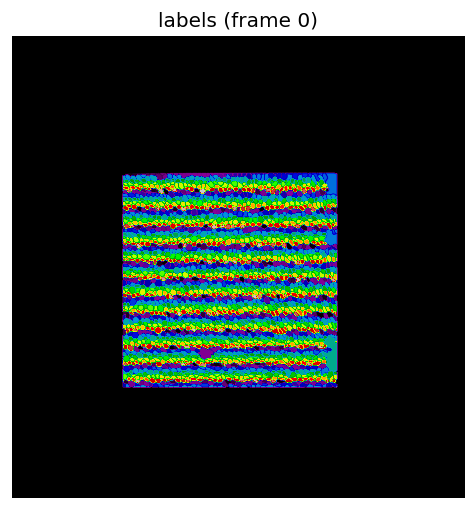

In [13]:
# Cell 5 — labeling only good frames, constrained to valid_roi
labels_dict = {}  # frame -> label image (int32)

for fr in tqdm(good_idx, desc="per-frame labeling (good+ROI)"):
    binary = (seg_work[fr] > 0) & valid_roi   # ← חשוב
    mask   = remove_small_objects(binary, PIX_MIN)
    if R_OPEN > 0:
        mask = opening(mask, disk(R_OPEN))
    labels_dict[fr] = measure.label(mask, connectivity=1)

# בדיקה קצרה
k = good_idx[0]
lbl = labels_dict[k]
print("unique components (frame", k, "):", lbl.max())
plt.figure(figsize=(5,5), dpi=120)
plt.imshow(lbl % 200, cmap='nipy_spectral'); plt.title(f"labels (frame {k})"); plt.axis('off')


# Cell 5.5 - Split Merges!

In [15]:
# === Cell 5.5 — FAST split merged blobs using prev-frame centroids (NO det_df dependency) ===
import numpy as np
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage import measure
from time import perf_counter

# פרמטרים לכיוונון
MIN_SEEDS_TO_SPLIT = 2       # כמה זרעים מינ' כדי לסמן קומפ' לפיצול
MIN_PIX_AREA       = PIX_MIN # התעלמות מקומפ' קטנות

good_sorted = sorted(good_idx)
TOTAL_SPLITS = 0

for t in good_sorted[1:]:
    tic = perf_counter()
    L  = labels_dict[t]       # תוויות הפריים הנוכחי (בתוך ה-ROI)
    if L.max() == 0:
        continue
    H, W = L.shape

    # === זרעים: צנטרואידים של קומפוננטות מהפריים הקודם (labels_dict[t-1]) ===
    L_prev = labels_dict.get(t-1, None)
    if L_prev is None or L_prev.max() == 0:
        continue

    # צנטרואידים במהירות יחסית
    seeds_y = []
    seeds_x = []
    for rp in measure.regionprops(L_prev):
        y, x = rp.centroid
        yy = int(round(y)); xx = int(round(x))
        if 0 <= yy < H and 0 <= xx < W:
            seeds_y.append(yy)
            seeds_x.append(xx)

    if not seeds_y:
        continue

    ys = np.asarray(seeds_y, dtype=int)
    xs = np.asarray(seeds_x, dtype=int)

    # כמה זרעים נופלים לכל תוית נוכחית בפריים t
    labs_at = L[ys, xs]                    # label id בפריים t עבור כל זרע
    counts  = np.bincount(labs_at, minlength=L.max()+1)

    # מועמדות לפיצול: לפחות MIN_SEEDS_TO_SPLIT זרעים ובנוסף לא-רקע
    need = np.flatnonzero(counts >= MIN_SEEDS_TO_SPLIT)
    need = need[need > 0]
    if need.size == 0:
        continue

    # בוקסים לכל תוית בצורה מהירה
    slices = ndi.find_objects(L)

    next_lbl = int(L.max()) + 1
    did = 0

    for lab in need:
        sl = slices[lab-1]
        if sl is None:
            continue

        sub = (L[sl] == lab)
        if int(sub.sum()) < MIN_PIX_AREA:
            continue

        # זרעים ששייכים לתוית הזו
        m = (labs_at == lab)
        if not np.any(m):
            continue
        ys_lab = ys[m] - sl[0].start
        xs_lab = xs[m] - sl[1].start

        # אם בפועל נשאר רק זרע יחיד בתוך ה־ROI של התוית — אין מה לפצל
        if ys_lab.size < MIN_SEEDS_TO_SPLIT:
            continue

        # מרקרים 1..k (פיקסל יחיד לכל זרע)
        markers = np.zeros(sub.shape, np.int32)
        markers[ys_lab, xs_lab] = np.arange(1, ys_lab.size+1, dtype=np.int32)

        # watershed מקומי על ה־ROI בלבד (על מרחק מהגבולות)
        D   = ndi.distance_transform_edt(sub)
        seg = watershed(-D, markers=markers, mask=sub)

        if seg.max() >= 2:
            # מחזירים: המקטע הראשון נשאר עם התוית הישנה; השאר מקבלים מזהים חדשים
            ids = np.unique(seg); ids = ids[ids > 0]
            keep = ids[0]
            for sid in ids:
                if sid == keep:
                    L[sl][seg == sid] = lab
                else:
                    L[sl][seg == sid] = next_lbl
                    next_lbl += 1
            did += 1

    labels_dict[t] = L
    TOTAL_SPLITS += did
    print(f"[5.5-fast(detdf-free)] frame {t}: split {did} blobs (candidates={len(need)}) in {perf_counter()-tic:.2f}s")

print(f"[5.5-fast(detdf-free)] total splits: {TOTAL_SPLITS}")


[5.5-fast(detdf-free)] frame 2: split 30 blobs (candidates=30) in 0.21s
[5.5-fast(detdf-free)] frame 3: split 28 blobs (candidates=28) in 0.27s
[5.5-fast(detdf-free)] frame 4: split 37 blobs (candidates=37) in 0.23s
[5.5-fast(detdf-free)] frame 5: split 37 blobs (candidates=37) in 0.23s
[5.5-fast(detdf-free)] frame 6: split 45 blobs (candidates=45) in 0.24s
[5.5-fast(detdf-free)] frame 7: split 43 blobs (candidates=43) in 0.25s
[5.5-fast(detdf-free)] frame 8: split 48 blobs (candidates=48) in 0.23s
[5.5-fast(detdf-free)] frame 9: split 47 blobs (candidates=47) in 0.23s
[5.5-fast(detdf-free)] frame 10: split 46 blobs (candidates=46) in 0.23s
[5.5-fast(detdf-free)] frame 11: split 44 blobs (candidates=44) in 0.24s
[5.5-fast(detdf-free)] frame 12: split 49 blobs (candidates=49) in 0.23s
[5.5-fast(detdf-free)] frame 13: split 47 blobs (candidates=47) in 0.22s
[5.5-fast(detdf-free)] frame 14: split 49 blobs (candidates=49) in 0.23s
[5.5-fast(detdf-free)] frame 15: split 48 blobs (candidates

# cell 6

CC → detections:   0%|          | 0/96 [00:00<?, ?it/s]

Detections: 224045 | per-frame ~ 2333


(-0.5, 4085.5, 4167.5, -0.5)

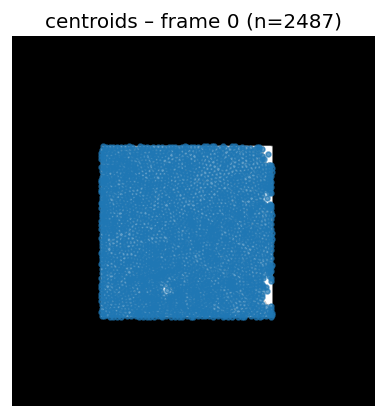

In [17]:
#Cell 6
detections = []
for fr in tqdm(good_idx, desc="CC → detections"):
    lbl = labels_dict[fr]
    for r in measure.regionprops(lbl):
        if r.area < PIX_MIN:
            continue
        y0, x0, y1, x1 = r.bbox
        detections.append({
            "frame": fr,
            "y": float(r.centroid[0]),
            "x": float(r.centroid[1]),
            "area": int(r.area),
            "bbox": (int(y0),int(x0),int(y1),int(x1)),
            "label": int(r.label)
        })

det_df = pd.DataFrame(detections)
print("Detections:", len(det_df), "| per-frame ~", int(len(det_df)/max(1,len(good_idx))))

# ויזואליה
k = good_idx[0]
dfk = det_df[det_df.frame==k]
plt.figure(figsize=(4,4), dpi=120)
plt.imshow(seg_work[k]>0, cmap='gray')
plt.scatter(dfk["x"], dfk["y"], s=8, alpha=0.7)
plt.title(f"centroids – frame {k} (n={len(dfk)})"); plt.axis('off')


# Diagnostic Cell - Split, Merge and death cause

In [19]:
# === Cell D0 — Step-by-step audit: merges, splits & deaths ===
from scipy.spatial import cKDTree
audit = []

good_sorted = sorted(good_idx)
for p,c in zip(good_sorted[:-1], good_sorted[1:]):
    P = det_df[det_df.frame==p][['y','x']].to_numpy()
    Q = det_df[det_df.frame==c][['y','x']].to_numpy()
    if len(P)==0 or len(Q)==0:
        continue
    # מוות: אין מועמד קרוב (לפי R_GATE_PRED)
    treeQ = cKDTree(Q)
    dP,_ = treeQ.query(P, k=1)
    deaths = int((dP > max(R_GATE, 1.5*R0_PIX)).sum())

    # merge: כמה נק' מפ' נופלות לאותה קומפוננטה ב־c
    Lc = labels_dict[c]
    yy = np.clip(np.rint(P[:,0]).astype(int), 0, Lc.shape[0]-1)
    xx = np.clip(np.rint(P[:,1]).astype(int), 0, Lc.shape[1]-1)
    labs_c = Lc[yy, xx]
    vals, cnts = np.unique(labs_c[labs_c>0], return_counts=True)
    merges = int((cnts>=2).sum())

    # split: הפוך (נק' מ־c על לייבלים של p)
    Lp = labels_dict[p]
    yy2 = np.clip(np.rint(Q[:,0]).astype(int), 0, Lp.shape[0]-1)
    xx2 = np.clip(np.rint(Q[:,1]).astype(int), 0, Lp.shape[1]-1)
    labs_p = Lp[yy2, xx2]
    vals2, cnts2 = np.unique(labs_p[labs_p>0], return_counts=True)
    splits = int((cnts2>=2).sum())

    audit.append(dict(pair=f"{p}->{c}", deaths=deaths, merges=merges, splits=splits, nP=len(P), nQ=len(Q)))

aud = pd.DataFrame(audit)
display(aud)
print("totals:", aud[['deaths','merges','splits']].sum().to_dict())


,pair,deaths,merges,splits,nP,nQ
0,0->1,1,0,0,2487,2465
1,1->2,0,0,32,2465,2470
2,2->3,0,0,0,2470,2450
3,3->4,0,0,11,2450,2474
4,4->5,0,0,0,2474,2455
...,...,...,...,...,...,...
90,94->95,2,0,0,2302,2258
91,95->96,7,0,12,2258,2283
92,96->97,6,0,0,2283,2256
93,97->98,2,0,12,2256,2256


totals: {'deaths': 320, 'merges': 32, 'splits': 718}


# Cell 6.1 כמה זזים כל פריים

In [21]:
# === B: תזוזת סנטרואידים בין פריימים סמוכים (דגימה) ===
from scipy.spatial import cKDTree

rng = np.random.default_rng(0)
step_dists = []

good_sorted = sorted(good_idx)
for f_prev, f_cur in zip(good_sorted[:-1], good_sorted[1:]):
    A = det_df[det_df.frame==f_prev][['y','x']].to_numpy()
    B = det_df[det_df.frame==f_cur ][['y','x']].to_numpy()
    if len(A)==0 or len(B)==0:
        continue
    # דוגמים עד 1000 נק' מ-A
    if len(A) > 1000:
        A = A[rng.choice(len(A), 1000, replace=False)]
    tree = cKDTree(B)
    d, _ = tree.query(A, k=1)
    step_dists.append(d)

if step_dists:
    d_all = np.concatenate(step_dists)
    p50, p90, p95 = np.percentile(d_all, [50,90,95])
    print(f"Δcentroid per step: p50={p50:.1f}px | p90={p90:.1f}px | p95={p95:.1f}px")
    print("→ suggest R_GATE ≈", int(np.ceil(p95*1.2)))
else:
    print("No steps measured (empty).")


Δcentroid per step: p50=0.1px | p90=5.2px | p95=7.4px
→ suggest R_GATE ≈ 9


# Cell 6.2 - Auto-gating from Δcentroid stats

In [23]:
# === Cell B0.9 — Auto-gating from Δcentroid stats ===
# דורש שהמשתנה step_dists הוגדר בתא "כמה זזים כל פריים"

import numpy as np

if step_dists:
    d_all = np.concatenate(step_dists)
    STEP_P50, STEP_P90, STEP_P95 = np.percentile(d_all, [50, 90, 95])

    # שערים אוטומטיים נגזרים:
    R_GATE_AUTO      = int(np.ceil(1.3 * STEP_P95))      # ~130% מה-p95
    R_GATE_PRED_AUTO = max(R_GATE_AUTO, int(2.5 * R0_PIX))

    # מגדירים/מעדכנים את המשתנים הגלובליים שבהם שאר התאים משתמשים:
    R_GATE      = R_GATE_AUTO
    R_GATE_PRED = R_GATE_PRED_AUTO

    print(f"[auto-gate] p50={STEP_P50:.1f}, p90={STEP_P90:.1f}, p95={STEP_P95:.1f}  →  "
          f"R_GATE={R_GATE} | R_GATE_PRED={R_GATE_PRED}")
else:
    # fallback: אם משום מה לא חושבו צעדים, לא נוגעים בשערים
    print(f"[auto-gate] no step distances available; keeping existing R_GATE={R_GATE}")


[auto-gate] p50=0.1, p90=5.2, p95=7.4  →  R_GATE=10 | R_GATE_PRED=110


## Cell B1 - Global jump diagnostics לא חובה להריץ זה רק לדיאגנוסטיקה בשבילי!

found 0 large pairs (≥25.0px) out of 95
0 **accepted** jumps  (inliers≥0.3 OR err≤0.85)


,prev,cur,dr,dc,mag,err,inlier_frac,mag_stage,cause_guess


wrote /Users/idanaviv/Downloads/final_project/implementation/DATA/residual_shifts_via_density.csv


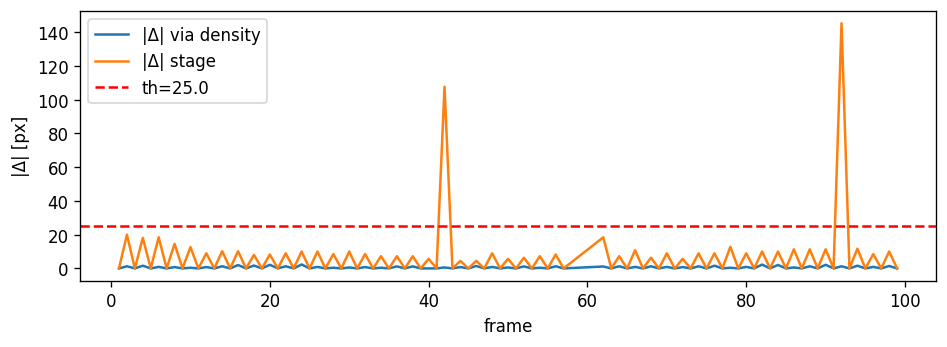

In [25]:
# === B1c — centroid-density correlation + inlier validation ===
from skimage.registration import phase_cross_correlation
from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree

good_sorted = sorted(good_idx)

# --- פרמטרים שניתנים לכיוונון ---
DS          = 4        # downscale לצפיפות (4=זריז ויציב; אם חלש → נסה DS=2)
SIGMA       = 2.0      # טשטוש גאוסיאני על מפות הצפיפות
JUMP_MIN    = 25.0     # פיקסלים – מינימום להיחשב "קפיצה"
ERR_MAX     = 0.85     # איכות התאמה מותרת (pcc error נמוך=טוב) – העלה אם מחמיץ
INLIER_RAD  = max(20.0, 0.9*R0_PIX)  # רדיוס inlier לאימות אחרי הזזה
INLIER_MIN  = 0.30     # יחס inliers מינימלי (הורד ל-0.2 אם צריך רגישות)
# ---------------------------------

H0, W0 = seg_work.shape[1:]
Hd, Wd = H0//DS, W0//DS

def make_density(frame_idx):
    """בונה מפה קטנה של צפיפות צנטרואידים (Hd x Wd) לפריים."""
    pts = det_df[det_df.frame==frame_idx][['y','x']].to_numpy()
    if pts.size == 0:
        return np.zeros((Hd,Wd), np.float32)
    yy = np.clip((pts[:,0] / DS).astype(int), 0, Hd-1)
    xx = np.clip((pts[:,1] / DS).astype(int), 0, Wd-1)
    den = np.zeros((Hd,Wd), np.float32)
    np.add.at(den, (yy,xx), 1.0)
    if SIGMA > 0:
        den = gaussian_filter(den, SIGMA, mode='nearest')
    s = den.sum()
    if s > 0: den /= s
    return den

def stage_between(prev, cur):
    if 'shifts_rc' not in globals() or cur <= prev:
        return 0.0, 0.0, 0.0
    inc = np.diff(shifts_rc, axis=0)  # (T-1,2):(dr,dc)
    seg = inc[prev:cur].sum(axis=0)   # סכום dr,dc בין prev..cur
    drs, dcs = float(seg[0]), float(seg[1])
    return drs, dcs, float(np.hypot(drs,dcs))

# חישוב קפיצות
rows = []
for prev, cur in zip(good_sorted[:-1], good_sorted[1:]):
    A = make_density(prev)
    B = make_density(cur)
    if A.sum()==0 or B.sum()==0:
        rows.append(dict(prev=prev, cur=cur, dr=np.nan, dc=np.nan,
                         mag=np.nan, err=np.nan, inlier_frac=0.0))
        continue

    # phase correlation על המפות הקטנות
    (dyd, dxd), err, _ = phase_cross_correlation(A, B, upsample_factor=10)
    dr = float(dyd*DS)  # חזרה לסקאלה מקורית
    dc = float(dxd*DS)
    mag = float(np.hypot(dr, dc))

    # אימות: מזיזים את הצנטרואידים של prev ובודקים כמה מהם נצמדים ל-cur
    P = det_df[det_df.frame==prev][['y','x']].to_numpy()
    Q = det_df[det_df.frame==cur ][['y','x']].to_numpy()
    if len(P)==0 or len(Q)==0:
        inlier_frac = 0.0
    else:
        tree = cKDTree(Q)
        dist, _ = tree.query(P + np.array([dr, dc])[None,:], k=1)
        inlier_frac = float((dist <= INLIER_RAD).mean())

    rows.append(dict(prev=prev, cur=cur, dr=dr, dc=dc,
                     mag=mag, err=float(err), inlier_frac=inlier_frac))

shift_est = pd.DataFrame(rows)

# הזרקת מידע מהבמה + ניחוש סיבה
drs=[]; dcs=[]; mags=[]
for r in shift_est.itertuples(index=False):
    ds = stage_between(r.prev, r.cur)
    drs.append(ds[0]); dcs.append(ds[1]); mags.append(ds[2])
shift_est['dr_stage'] = drs
shift_est['dc_stage'] = dcs
shift_est['mag_stage'] = mags
shift_est['cause_guess'] = [
    ('camera?' if abs(r.mag - r.mag_stage) < 6.0 else 'tissue?')
    for r in shift_est.itertuples(index=False)
]

# החלטה: Jump אם גדול וגם (inliers מספיק או error סביר)
jm = (shift_est.mag >= JUMP_MIN) & ((shift_est.inlier_frac >= INLIER_MIN) | (shift_est.err <= ERR_MAX))
jumps = shift_est[jm].copy().reset_index(drop=True)

print(f"found {(shift_est.mag >= JUMP_MIN).sum()} large pairs (≥{JUMP_MIN}px) out of {len(shift_est)}")
print(f"{len(jumps)} **accepted** jumps  (inliers≥{INLIER_MIN} OR err≤{ERR_MAX})")
display(jumps[['prev','cur','dr','dc','mag','err','inlier_frac','mag_stage','cause_guess']].head(30))

# לשימוש בתא 7: מילון offsets ליישור זמני של cur אל prev
OFFSETS = {(int(r.prev), int(r.cur)): (-float(r.dr), -float(r.dc)) for r in jumps.itertuples(index=False)}

# שמירה + גרף
CSV = DATA_DIR / "residual_shifts_via_density.csv"
shift_est.to_csv(CSV, index=False)
print("wrote", CSV)

plt.figure(figsize=(8,3), dpi=120)
plt.plot(shift_est['cur'], shift_est['mag'], label='|Δ| via density')
plt.plot(shift_est['cur'], shift_est['mag_stage'], label='|Δ| stage')
plt.axhline(JUMP_MIN, ls='--', c='r', label=f"th={JUMP_MIN}")
plt.xlabel("frame"); plt.ylabel("|Δ| [px]"); plt.legend(); plt.tight_layout()


# cell 7

In [27]:
# === Cell 7v++ (HOTFIX) — simpler, robust gating + diagnostics ===
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
from scipy.spatial import cKDTree
from collections import deque, Counter
import numpy as np, pandas as pd
from tqdm.auto import tqdm

tracks, tracks_meta = {}, {}
next_tid, prev_df, prev_fr = 1, None, None

# ---- params (מפושט/מחוזק) ----
AREA_RATIO_MIN, AREA_RATIO_MAX = 0.25, 4.0
W_PRED, W_PREV   = 0.6, 0.4
LAMBDA_IOU_BASE  = 0.4
LAMBDA_IOU_NEAR  = 0.8
R_IOU            = int(1.2*R0_PIX)
GAMMA_ACC        = 0.10            # מונמך
BETA_PROX        = 0.30
COST_THR_EFF     = 0.98

#R_GATE_PRED = max(R_GATE, int(3.5*R0_PIX))
# אם כבר חושב שער אוטומטי קודם, נשמור עליו; אחרת נגדיר ברירת מחדל סולידית
if 'R_GATE_PRED' not in globals():
    R_GATE_PRED = max(R_GATE, int(3.5*R0_PIX))


CLS_UNKNOWN, CLS_HAIR, CLS_SUP = 0, 1, 2
C_CLASS_DIFF  = 0.10
C_HAIR2SUP    = 0.30

K_VOTE, HAIR_COMMIT_FRAC, HAIR_COMMIT_STREAK = 10, 0.60, 3

def class_at(frame_idx, yx):
    y = int(round(float(yx[0]))); x = int(round(float(yx[1])))
    y = np.clip(y, 0, seg_full_cls.shape[1]-1)
    x = np.clip(x, 0, seg_full_cls.shape[2]-1)
    v = int(seg_full_cls[frame_idx, y, x])
    if v == 1: return CLS_HAIR
    if v == 2: return CLS_SUP
    return CLS_UNKNOWN

def update_votes(tid, cls):
    m = tracks_meta.setdefault(tid, {'votes': deque(maxlen=K_VOTE),
                                     'committed_hair': False})
    m['votes'].append(cls)
    if not m['committed_hair']:
        v = list(m['votes'])
        if len(v) >= min(5, K_VOTE):
            frac_h = (np.array(v) == CLS_HAIR).mean()
            streak = 0
            for tcls in reversed(v):
                if tcls == CLS_HAIR: streak += 1
                else: break
            if frac_h >= HAIR_COMMIT_FRAC and streak >= HAIR_COMMIT_STREAK:
                m['committed_hair'] = True

def last_vel_of_track(lst):
    if len(lst) >= 2:
        dy = lst[-1]['y'] - lst[-2]['y']; dx = lst[-1]['x'] - lst[-2]['x']
        return np.array([dy, dx], float)
    return np.array([0.0, 0.0], float)

stats = Counter()

for fr in tqdm(good_idx, desc="Tracking (7v++ hotfix)"):
    cur = det_df[det_df.frame == fr].copy().reset_index(drop=True)
    cur_cls = np.array([class_at(fr, (row.y, row.x)) for row in cur.itertuples()], dtype=np.int8)
    cur["cls"] = cur_cls

    if prev_df is None:
        cur["track_id"] = range(next_tid, next_tid + len(cur))
        for tid, row, cls in zip(cur["track_id"], cur.itertuples(), cur_cls):
            tracks[int(tid)] = [row._asdict()]
            update_votes(int(tid), int(cls))
        next_tid += len(cur)
        prev_df, prev_fr = cur[["track_id","bbox","y","x","frame","label","area","cls"]].copy(), fr
        continue

    prev_xy    = prev_df[["y","x"]].values
    cur_xy     = cur[["y","x"]].values
    prev_boxes = np.stack(prev_df["bbox"].values)
    cur_boxes  = np.stack(cur["bbox"].values)

    prev_cls = np.array([class_at(prev_fr, (row.y, row.x)) for row in prev_df.itertuples()], dtype=np.int8)
    prev_tid = prev_df['track_id'].astype(int).to_numpy()
    prev_committed = np.array([tracks_meta.get(int(t), {}).get('committed_hair', False) for t in prev_tid], dtype=bool)

    V = np.vstack([last_vel_of_track(tracks[int(t)]) for t in prev_tid])
    pred_xy = prev_xy + V

    dist_prev = cdist(prev_xy, cur_xy)
    dist_pred = cdist(pred_xy,  cur_xy)

    y0 = np.maximum(prev_boxes[:,None,0], cur_boxes[None,:,0])
    x0 = np.maximum(prev_boxes[:,None,1], cur_boxes[None,:,1])
    y1 = np.minimum(prev_boxes[:,None,2], cur_boxes[None,:,2])
    x1 = np.minimum(prev_boxes[:,None,3], cur_boxes[None,:,3])
    inter = np.clip(y1-y0,0,None) * np.clip(x1-x0,0,None)
    area_prev = (prev_boxes[:,2]-prev_boxes[:,0])*(prev_boxes[:,3]-prev_boxes[:,1])
    area_cur  = (cur_boxes[:,2]-cur_boxes[:,0]) *(cur_boxes[:,3]-cur_boxes[:,1])
    iou_mat   = inter / (area_prev[:,None] + area_cur[None,:] - inter + 1e-9)

    ratio = np.maximum(area_prev[:,None]/(area_cur[None,:]+1e-6),
                       area_cur[None,:]/(area_prev[:,None]+1e-6))
    mask_area = (ratio < AREA_RATIO_MIN) | (ratio > AREA_RATIO_MAX)

    # 🔧 BUGFIX: פסילה רק אם שניהם רחוקים (AND), לא OR
    mask_far  = (dist_prev > R_GATE) & (dist_pred > R_GATE_PRED)

    mat_prev_cls = np.repeat(prev_cls[:,None], len(cur), axis=1)
    mat_cur_cls  = np.repeat(cur_cls[None,:],  len(prev_cls), axis=0)
    forb = (np.repeat(prev_committed[:,None], len(cur), axis=1)) & (mat_cur_cls == CLS_SUP)

    diff = ((mat_prev_cls == CLS_HAIR) & (mat_cur_cls == CLS_SUP)) | \
           ((mat_prev_cls == CLS_SUP)  & (mat_cur_cls == CLS_HAIR))
    unk  = (mat_prev_cls == CLS_UNKNOWN) ^ (mat_cur_cls == CLS_UNKNOWN)
    class_pen = np.zeros_like(iou_mat, float)
    class_pen[diff] += C_CLASS_DIFF
    class_pen[(mat_prev_cls == CLS_HAIR) & (mat_cur_cls == CLS_SUP)] += (C_HAIR2SUP - C_CLASS_DIFF)
    class_pen[unk]  += 0.05

    weight_iou = np.where(dist_prev <= R_IOU, LAMBDA_IOU_NEAR, LAMBDA_IOU_BASE)

    acc  = (cur_xy[None,:,:] - prev_xy[:,None,:]) - V[:,None,:]
    acc_mag = np.hypot(acc[...,0], acc[...,1])

    cost = (W_PRED * (dist_pred/(R0_PIX+1e-6)) +
            W_PREV * (dist_prev/(R0_PIX+1e-6)) +
            weight_iou * (1 - iou_mat) +
            GAMMA_ACC  * (acc_mag/(R0_PIX+1e-6)) +
            class_pen)

    bonus = np.exp(- (dist_pred / (R0_PIX+1e-6))**2 ) * BETA_PROX
    cost = np.clip(cost - bonus, 0, 1)

    # חסימות
    cost[mask_area | mask_far | forb] = 1.0

    # דיאגנוסטיקה: כמה שורות ללא מועמדים אחרי חסימות
    row_has_cand = np.any(cost < 1.0, axis=1)
    stats['rows_no_candidates'] += int((~row_has_cand).sum())

    # רמיזת merge: שתי שורות שבוחרות את אותו עמוד
    row_best_j = np.argmin(cost, axis=1)
    cnt = Counter(row_best_j[row_has_cand].tolist())
    stats['suspected_merges'] += sum(v>1 for v in cnt.values())

    # --- נעילות הדדיות (רכה) ---
    n_prev, n_cur = cost.shape
    row_best_c = cost[np.arange(n_prev), row_best_j]
    _tmp = cost.copy()
    _tmp[np.arange(n_prev), row_best_j] = np.inf
    row_second = _tmp.min(axis=1)
    col_best_i = np.argmin(cost, axis=0)

    DELTA_LOCK = 0.02  # מעט רך יותר
    locked, used_prev, used_cur = [], set(), set()
    for i in range(n_prev):
        j = int(row_best_j[i])
        ok_dist = (dist_prev[i,j] <= R_GATE) or (dist_pred[i,j] <= R_GATE_PRED)
        if (col_best_i[j] == i and ok_dist and
            row_best_c[i] < COST_THR_EFF and
            (row_second[i] - row_best_c[i]) >= DELTA_LOCK):
            locked.append((i, j)); used_prev.add(i); used_cur.add(j)
    stats['locked'] += len(locked)

    row_free = [i for i in range(n_prev) if i not in used_prev]
    col_free = [j for j in range(n_cur)  if j not in used_cur]

    pairs = list(locked)
    if row_free and col_free:
        sub_cost = cost[np.ix_(row_free, col_free)]
        r_ind, c_ind = linear_sum_assignment(sub_cost)
        for rr, cc in zip(r_ind, c_ind):
            i = row_free[int(rr)]; j = col_free[int(cc)]
            if sub_cost[rr, cc] < COST_THR_EFF:
                pairs.append((i, j))
    stats['pairs'] += len(pairs)

    # --- תיקון 2-swap מקומי ---
    if len(pairs) >= 2:
        assign = {r: c for r, c in pairs}
        tree_prev = cKDTree(prev_xy)
        NEI_RAD   = int(1.2*R0_PIX)
        SWAP_MARG = 0.02 * R0_PIX
        for r in list(assign.keys()):
            for rr in tree_prev.query_ball_point(prev_xy[r], NEI_RAD):
                if rr <= r or rr not in assign: continue
                c1, c2 = assign[r], assign[rr]
                cur_sum = cost[r, c1] + cost[rr, c2]
                alt_sum = cost[r, c2] + cost[rr, c1]
                ok_alt = (cost[r, c2] < COST_THR_EFF and cost[rr, c1] < COST_THR_EFF)
                if ok_alt and (alt_sum + (SWAP_MARG/(R0_PIX+1e-6)) < cur_sum):
                    assign[r], assign[rr] = c2, c1
        pairs = list(assign.items())

    # --- יישום התאמות ---
    cur["track_id"] = np.nan
    for r, j in pairs:
        tid = int(prev_df.iloc[r].track_id)
        cur.at[j, 'track_id'] = tid
        tracks[tid].append(cur.loc[j].to_dict())
        update_votes(tid, int(cur_cls[j]))

    # פתיחת חדשים
    births = 0
    for j in range(len(cur)):
        if pd.isna(cur.loc[j, 'track_id']):
            tid = next_tid; next_tid += 1; births += 1
            cur.at[j, 'track_id'] = tid
            tracks[tid] = [cur.loc[j].to_dict()]
            update_votes(tid, int(cur_cls[j]))
    stats['births'] += births

    prev_df, prev_fr = cur[["track_id","bbox","y","x","frame","label","area","cls"]].copy(), fr

lens = np.array([len(v) for v in tracks.values()])
print("=== tracking summary (7v++ hotfix) ===")
print(f"Total tracks: {len(lens)} | mean len={lens.mean():.2f} | median={np.median(lens):.1f} | p90={np.percentile(lens,90):.1f}")
print(f"singleton tracks: {(lens==1).sum()} ({(lens==1).mean()*100:.1f}%)")
print(f"[diag] locked={stats['locked']}  pairs={stats['pairs']}  births={stats['births']}  rows_no_candidates={stats['rows_no_candidates']}  suspected_merges={stats['suspected_merges']}")


Tracking (7v++ hotfix):   0%|          | 0/96 [00:00<?, ?it/s]

=== tracking summary (7v++ hotfix) ===
Total tracks: 5827 | mean len=38.45 | median=12.0 | p90=96.0
singleton tracks: 1086 (18.6%)
[diag] locked=218144  pairs=218218  births=3340  rows_no_candidates=3204  suspected_merges=416


# Cell 7.5 — flatten `tracks` into a DataFrame for painting

In [29]:
# Cell 7.5 — flatten `tracks` into a DataFrame for painting
rows = []
for tid, dets in tracks.items():
    for d in dets:
        r = dict(d)              # frame, y, x, area, bbox, label, ...
        r['track_id'] = tid
        rows.append(r)

track_df = pd.DataFrame(rows)
print("track_df:", len(track_df), "rows | frames:", track_df['frame'].nunique())
print(track_df.columns.tolist()[:10], "…")

# דיאגנוסטיקה לאורך מסלולים
lens = np.array([len(v) for v in tracks.values()])
print(f"Total tracks: {len(lens)}")
print(f"mean len={lens.mean():.2f} | median={np.median(lens):.1f} | p90={np.percentile(lens,90):.1f}")
print(f"singleton tracks (len=1): {(lens==1).sum()}  ({(lens==1).mean()*100:.1f}%)")



track_df: 224045 rows | frames: 96
['Index', 'frame', 'y', 'x', 'area', 'bbox', 'label', 'cls', 'track_id'] …
Total tracks: 5827
mean len=38.45 | median=12.0 | p90=96.0
singleton tracks (len=1): 1086  (18.6%)


# Cell 7.6 — Bridge short gaps

In [31]:
# === Cell 7.6 — Bridge short gaps (≤G frames) with NO-BRANCH constraint ===
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import numpy as np, pandas as pd

GAP_MAX = 4

# שער מרחק לגישור (drift-space); גדל עם שורש הפער
R_BRIDGE_BASE = int(2.5*R0_PIX)  # היה 2.0*R0
# previous calc - R_BRIDGE_BASE = max(R_GATE, int(1.5*R0_PIX))
AREA_MIN_B, AREA_MAX_B = 0.4, 2.5
TH_COST_BRIDGE = 0.90

# --- קצוות המסלולים (כמו קודם) ---
g = track_df.groupby('track_id')
idx_last  = g['frame'].idxmax()
idx_first = g['frame'].idxmin()

ends = (track_df.loc[idx_last,  ['track_id','frame','y','x','area']]
        .rename(columns={'frame':'end_fr','y':'y_end','x':'x_end','area':'a_end'})
        .reset_index(drop=True))
starts = (track_df.loc[idx_first, ['track_id','frame','y','x','area']]
          .rename(columns={'frame':'start_fr','y':'y_start','x':'x_start','area':'a_start'})
          .reset_index(drop=True))

# מהירות פשוטה
def last2_vel(df):
    d = df.sort_values('frame').tail(2)
    if len(d)==2:
        return pd.Series({'vy': float(d.iloc[1]['y']-d.iloc[0]['y']),
                          'vx': float(d.iloc[1]['x']-d.iloc[0]['x'])})
    return pd.Series({'vy':0.0,'vx':0.0})
vel = g.apply(last2_vel, include_groups=False).reset_index()
ends = ends.merge(vel, on='track_id', how='left').fillna(0.0)

starts_by_fr = {fr: s for fr, s in starts.groupby('start_fr')}

# --- איסוף צמדי מיזוג מועמדים (כמו קודם) ---
merge_pairs = []  # (tid_end, tid_start, gap, dist, end_fr, start_fr)
for gap in range(1, GAP_MAX+1):
    cand_ends = ends.copy()
    cand_ends['target_fr'] = cand_ends['end_fr'] + gap
    cand_ends = cand_ends[cand_ends['target_fr'].isin(starts_by_fr)]
    if cand_ends.empty:
        continue

    for target_fr, e_df in cand_ends.groupby('target_fr'):
        s_df = starts_by_fr[target_fr]
        if s_df.empty or e_df.empty:
            continue

        # חיזוי מיקום קצה
        e_pred_y = e_df['y_end'].to_numpy() + e_df['vy'].to_numpy()*gap
        e_pred_x = e_df['x_end'].to_numpy() + e_df['vx'].to_numpy()*gap
        E = np.column_stack([e_pred_y, e_pred_x])
        S = s_df[['y_start','x_start']].to_numpy()
        D = cdist(E, S)

        R_eff = R_BRIDGE_BASE * np.sqrt(gap)
        area_ratio = np.maximum(
            (e_df['a_end'].to_numpy()[:,None])/(s_df['a_start'].to_numpy()[None,:]+1e-6),
            (s_df['a_start'].to_numpy()[None,:])/(e_df['a_end'].to_numpy()[:,None]+1e-6)
        )
        mask_far  = (D > R_eff)
        mask_area = (area_ratio < AREA_MIN_B) | (area_ratio > AREA_MAX_B)

        D_masked = D.copy()
        D_masked[mask_far | mask_area] = 1e9

        cost = (D_masked/(R0_PIX+1e-6)) + 0.2*np.abs(np.log(area_ratio))

        r_ind, c_ind = linear_sum_assignment(cost)
        for i,j in zip(r_ind, c_ind):
            cval = cost[i,j]
            if not np.isfinite(cval):
                continue
            if cval < TH_COST_BRIDGE or D[i,j] < 0.75*R_eff:
                tid_end   = int(e_df.iloc[i]['track_id'])
                tid_start = int(s_df.iloc[j]['track_id'])
                if tid_end != tid_start:
                    merge_pairs.append(
                        (tid_end, tid_start, gap, float(D[i,j]),
                         int(e_df.iloc[i]['end_fr']), int(s_df.iloc[j]['start_fr']))
                    )

# --- החלת מיזוגים בצורה שאין הסתעפויות/התכנסויות ---
# כל "שורש" (מסלול) יכול לקבל לכל היותר יורש אחד ובמקביל לכל היותר אב אחד.
# מטפלים בזמן-אמת עם Union-Find + שמירת הפריים האחרון של כל שרשרת.

# מפות עזר
end_fr_map   = dict(zip(ends.track_id,   ends.end_fr))
start_fr_map = dict(zip(starts.track_id, starts.start_fr))

# Union-Find
parent = {}
def find(t):
    while t in parent:
        t = parent[t]
    return t

# bookkeeping
last_fr = {tid: end_fr_map.get(tid, -10**9) for tid in track_df['track_id'].unique()}
succ_used  = set()  # לכל שורש "סוף" מותר יורש אחד
pred_used  = set()  # לכל שורש "התחלה" מותר אב אחד

# נמיין: קודם לפי start_fr (מוקדם→מאוחר), אח״כ לפי gap, אח״כ מרחק
merge_pairs.sort(key=lambda x: (x[5], x[2], x[3]))

applied = []
for a, b, gap, dist, end_fr, start_fr in merge_pairs:
    ra, rb = find(a), find(b)
    if ra == rb:
        continue
    # אין חפיפה בזמן
    if last_fr.get(ra, -10**9) >= start_fr_map.get(rb, start_fr):
        continue
    # אין הסתעפות/התכנסות
    if ra in succ_used or rb in pred_used:
        continue

    # מאחדים: rb ← ra
    parent[rb] = ra
    succ_used.add(ra)
    pred_used.add(rb)

    # עדכון הפריים האחרון של השרשרת המאוחדת
    last_fr[ra] = max(last_fr.get(ra, -10**9), last_fr.get(rb, end_fr_map.get(rb, -10**9)))

# רימפינג track_ids לשורשים
if parent:
    roots = {tid: find(tid) for tid in track_df['track_id'].unique()}
    track_df['track_id'] = track_df['track_id'].map(roots).astype(int)
    lens = track_df.groupby('track_id')['frame'].size().values
    print(f"[bridge] applied {len(parent)} merges | tracks now: {len(lens)}")
    print(f"[bridge] mean len={lens.mean():.2f} | median={np.median(lens):.1f} | p90={np.percentile(lens,90):.1f}")
else:
    print("[bridge] no merges applied")

# --- בדיקת תקינות: אין שני דיטקציות עם אותו ID באותו פריים ---
dup = (track_df.groupby(['frame','track_id']).size().reset_index(name='n'))
bad = dup[dup['n'] > 1]
if len(bad):
    print(f"⚠️ found {len(bad)} (frame,track_id) collisions. "
          f"מציע להחמיר ספים או GAP_MAX, אחרת אפשר להפעיל SAFE_SPLIT.")
else:
    print("✅ no per-frame ID collisions after bridging.")


[bridge] applied 1114 merges | tracks now: 4713
[bridge] mean len=47.54 | median=32.0 | p90=96.0
✅ no per-frame ID collisions after bridging.


# Cell 7.6C

In [33]:
# === Cell 7.6c — One-frame ABA de-flicker (optional but effective) ===
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd

R_SMOOTH = max(25.0, 0.8*R0_PIX)   # רדיוס שכנות לאימות
good_sorted = sorted(good_idx)

changes = 0
for c in good_sorted[1:-1]:
    P = track_df[track_df.frame==c-1][['track_id','y','x']].reset_index(drop=True)
    C = track_df[track_df.frame==c  ][['track_id','y','x']].reset_index()
    N = track_df[track_df.frame==c+1][['track_id','y','x']].reset_index(drop=True)
    if len(P)==0 or len(C)==0 or len(N)==0:
        continue

    treeP = cKDTree(P[['y','x']].to_numpy())
    treeN = cKDTree(N[['y','x']].to_numpy())

    used_ids = set()  # כדי למנוע שני מופעים של אותו ID באותו פריים
    for idx,row in C.iterrows():
        yx = np.array([row['y'], row['x']])
        dP, iP = treeP.query(yx, k=1)
        dN, iN = treeN.query(yx, k=1)
        if dP <= R_SMOOTH and dN <= R_SMOOTH:
            idP = int(P.iloc[iP]['track_id'])
            idN = int(N.iloc[iN]['track_id'])
            idC = int(row['track_id'])
            if idP == idN and idP != idC and idP not in used_ids:
                # מחליף את ה-ID בפריים האמצעי
                track_df.loc[row['index'], 'track_id'] = idP
                used_ids.add(idP)
                changes += 1

print(f"[de-flicker] applied {changes} one-frame ID fixes")


[de-flicker] applied 346 one-frame ID fixes


# Cell 7.6d - local swap fix

In [35]:
'''
# === Cell 7.6d — Deterministic local swap fix (apply AFTER 7.6c) ===
from scipy.spatial import cKDTree
NEI_RAD = int(1.2*R0_PIX)
R_NEAR  = max(18.0, 0.8*R0_PIX)
MARGIN  = 0.02 * R0_PIX

good_sorted = sorted(good_idx)
fixes = 0
for p,c in zip(good_sorted[:-1], good_sorted[1:]):
    P = track_df[track_df.frame==p][['track_id','y','x']].reset_index(drop=True)
    Q = track_df[track_df.frame==c][['track_id','y','x']].reset_index().rename(columns={'index':'idx'})
    if len(P)==0 or len(Q)==0:
        continue
    Pxy, Qxy = P[['y','x']].to_numpy(), Q[['y','x']].to_numpy()
    treeQ, treeP = cKDTree(Qxy), cKDTree(Pxy)
    dPQ, iPQ = treeQ.query(Pxy, k=1)
    P['q_idx'] = iPQ; P['d_q'] = dPQ

    used = set()
    for i,row in P.iterrows():
        if row['d_q'] > R_NEAR: 
            continue
        qi = int(row['q_idx'])
        for j in treeP.query_ball_point(Pxy[i], NEI_RAD):
            if j==i: continue
            qj = int(P.iloc[j]['q_idx'])
            cur_sum   = P.iloc[i]['d_q'] + P.iloc[j]['d_q']
            cross_sum = np.linalg.norm(Qxy[qj] - Pxy[i]) + np.linalg.norm(Qxy[qi] - Pxy[j])
            if (cross_sum + MARGIN < cur_sum) and (Q.loc[qi,'track_id']!=Q.loc[qj,'track_id']):
                # מחליף IDs בפריים c
                id_i = int(Q.loc[qi,'track_id']); id_j = int(Q.loc[qj,'track_id'])
                Q.loc[qi,'track_id'], Q.loc[qj,'track_id'] = id_j, id_i
                used.add(qi); used.add(qj); fixes += 1
    # כותב בחזרה
    track_df.loc[track_df.frame==c, 'track_id'] = Q.sort_values('idx')['track_id'].to_numpy()

print(f"[7.6d] applied {fixes} local swap fixes")
'''

'\n# === Cell 7.6d — Deterministic local swap fix (apply AFTER 7.6c) ===\nfrom scipy.spatial import cKDTree\nNEI_RAD = int(1.2*R0_PIX)\nR_NEAR  = max(18.0, 0.8*R0_PIX)\nMARGIN  = 0.02 * R0_PIX\n\ngood_sorted = sorted(good_idx)\nfixes = 0\nfor p,c in zip(good_sorted[:-1], good_sorted[1:]):\n    P = track_df[track_df.frame==p][[\'track_id\',\'y\',\'x\']].reset_index(drop=True)\n    Q = track_df[track_df.frame==c][[\'track_id\',\'y\',\'x\']].reset_index().rename(columns={\'index\':\'idx\'})\n    if len(P)==0 or len(Q)==0:\n        continue\n    Pxy, Qxy = P[[\'y\',\'x\']].to_numpy(), Q[[\'y\',\'x\']].to_numpy()\n    treeQ, treeP = cKDTree(Qxy), cKDTree(Pxy)\n    dPQ, iPQ = treeQ.query(Pxy, k=1)\n    P[\'q_idx\'] = iPQ; P[\'d_q\'] = dPQ\n\n    used = set()\n    for i,row in P.iterrows():\n        if row[\'d_q\'] > R_NEAR: \n            continue\n        qi = int(row[\'q_idx\'])\n        for j in treeP.query_ball_point(Pxy[i], NEI_RAD):\n            if j==i: continue\n            qj = int(P

# Cell 7C - Class smoothing & monotone correction (support→hair only)

In [37]:
# === 7C — p_t + causal commit (bugfix: שומר track_id ומטפל ב-0 אירועים) ===
import numpy as np, pandas as pd
from skimage.draw import disk

# --- העדפות מחמירות יותר (כמו אצלך) ---
W_MAJ              = 15
TH_FRAC            = 0.80
K_CONSEC           = 4
PRE_HAIR_TRACK_FRAC= 0.90
E_RAD              = 6
MIN_AFTER          = 5  # ליצוא "חזק"

# בדיקות תלות בסיסיות
for v in ('seg_full_cls','shifts_rc','pad_top','pad_left','DATA_DIR','track_df'):
    if v not in globals():
        raise RuntimeError(f"נדרש {v} מהתאים הקודמים.")
H0, W0 = seg_full_cls.shape[1:]

def spatial_hair_fraction(fr, y_d, x_d):
    dr, dc = shifts_rc[int(fr)]
    y = int(round(float(y_d - dr - pad_top)))
    x = int(round(float(x_d - dc - pad_left)))
    if not (0 <= y < H0 and 0 <= x < W0):
        return np.nan
    rr, cc = disk((y, x), E_RAD, shape=(H0, W0))
    patch = seg_full_cls[int(fr), rr, cc].astype(float)
    m = np.isin(patch, [1.0, 2.0])  # hair=1, support=2; 0/3 → NaN
    if not np.any(m):
        return np.nan
    return float(np.nanmean(patch[m] == 1.0))

# --- שלב 1: p_t לכל שורה ---
pt_chunks = []
for fr, g in track_df.groupby('frame'):
    pvals = [spatial_hair_fraction(int(fr), r.y, r.x) for r in g.itertuples()]
    pt_chunks.append(pd.DataFrame({
        'frame': int(fr),
        'track_id': g['track_id'].astype(int).to_numpy(),
        'p_t': pvals
    }))
pt_df = pd.concat(pt_chunks, ignore_index=True)

track_df = (track_df
            .drop(columns=[c for c in ['p_t','cls_raw'] if c in track_df.columns])
            .merge(pt_df, on=['frame','track_id'], how='left')
            .sort_values(['track_id','frame'])
            .reset_index(drop=True))

# --- שלב 2: commit סיבתי על סמך \bar{p}_t (עבר בלבד) + רצף ---
rows_events = []

def smooth_causal_commit(gr: pd.DataFrame) -> pd.DataFrame:
    gr = gr.sort_values('frame').copy()
    frames = gr['frame'].astype(int).to_numpy()
    p      = gr['p_t'].astype(float).to_numpy()
    n = len(gr)

    pbar = np.full(n, np.nan, float)
    run  = np.zeros(n, int)
    for i in range(n):
        lo = max(0, i - W_MAJ + 1)
        win = p[lo:i+1]
        pbar[i] = (np.nanmean(win) if np.any(np.isfinite(win)) else np.nan)
        is_hair_now = (p[i] > 0.5) if np.isfinite(p[i]) else False
        run[i] = (run[i-1] + 1) if (i>0 and is_hair_now) else (1 if is_hair_now else 0)

    idx_commit = -1
    for i in range(n):
        if np.isfinite(pbar[i]) and pbar[i] >= TH_FRAC and run[i] >= K_CONSEC:
            idx_commit = i; break

    if idx_commit >= 0:
        gr['cls_fixed']      = np.where(np.arange(n) >= idx_commit, 1, 2).astype(np.int16)
        gr['committed_hair'] = True
        gr['commit_frame']   = int(frames[idx_commit])

        pre = p[:idx_commit]; pre = pre[np.isfinite(pre)]
        pre_mean = pre.mean() if pre.size else 0.0
        if pre_mean <= 0.20:  # “באמת היו תומך” לפני
            rows_events.append({
                'track_id':      int(gr['track_id'].iloc[0]),
                'commit_frame':  int(frames[idx_commit]),
                'frames_before': int(idx_commit),
                'frames_after':  int(n - idx_commit),
                'y_commit':      float(gr['y'].iloc[idx_commit]),
                'x_commit':      float(gr['x'].iloc[idx_commit]),
                'evidence_run':  int(run[idx_commit]),
                'evidence_frac': float(pbar[idx_commit]),
            })
    else:
        finite = p[np.isfinite(p)]
        frac = finite.mean() if finite.size else 0.0
        pre_hair = (frac >= PRE_HAIR_TRACK_FRAC)
        fixed = 1 if pre_hair else 2
        gr['cls_fixed']      = np.full(n, fixed, np.int16)
        gr['committed_hair'] = bool(pre_hair)
        gr['commit_frame']   = int(frames[0]) if pre_hair else -1

    return gr

# ←←← BUGFIX: במקום groupby.apply (שעלול "לאבד" את track_id) — לולאה שקולה:
out = []
for tid, grp in track_df.groupby('track_id', sort=False):
    g2 = smooth_causal_commit(grp)
    g2['track_id'] = int(tid)  # מבטיח שהעמודה קיימת
    out.append(g2)
track_df = pd.concat(out, ignore_index=True)

# --- כתיבת אירועים (base) ---
ev_df = pd.DataFrame(rows_events)
ev_df.to_csv(DATA_DIR / "events_differentiation.csv", index=False)
print(f"[7C+] events: {len(ev_df)} written (causal window + spatial evidence)")

# --- 7C — export (strong) עם טיפול במצב שאין אירועים ---
cols = ['track_id','commit_frame',
        'frames_before','frames_after',
        'track_min_frame','track_max_frame',
        'y_commit','x_commit','evidence_run','evidence_frac']

if ev_df.empty:
    pd.DataFrame(columns=cols).to_csv(DATA_DIR / "events_differentiation_strong.csv", index=False)
    print("[7C-strong] no events; wrote empty CSV with headers.")
else:
    bounds = (track_df.groupby('track_id')['frame']
                        .agg(track_min_frame='min', track_max_frame='max')
                        .reset_index())
    ev_df = ev_df.merge(bounds, on='track_id', how='left')
    ev_df['frames_before'] = ev_df['commit_frame'] - ev_df['track_min_frame']
    ev_df['frames_after']  = ev_df['track_max_frame'] - ev_df['commit_frame'] + 1
    ok = (ev_df['frames_before'] >= 0) & (ev_df['frames_after'] >= 1) & \
         (ev_df['track_min_frame'] <= ev_df['commit_frame']) & \
         (ev_df['commit_frame'] <= ev_df['track_max_frame'])
    bad = (~ok).sum()
    if bad:
        print(f"[7C-strong] משליך {bad} אירועים לא תקינים (commit מחוץ לגבולות).")
    ev_df = ev_df[ok].copy()
    before_n = len(ev_df)
    ev_df = ev_df[ev_df['frames_after'] >= MIN_AFTER].copy()
    print(f"[7C-strong] נשמרו {len(ev_df)} אירועים (מתוך {before_n}). MIN_AFTER={MIN_AFTER}")
    ev_df[cols].to_csv(DATA_DIR / "events_differentiation_strong.csv", index=False)
    print("[7C-strong] wrote → events_differentiation_strong.csv")


[7C+] events: 0 written (causal window + spatial evidence)
[7C-strong] no events; wrote empty CSV with headers.


In [38]:
# === 7C-filter-v2 — סינון אירועי דיפרנציאציה והוספת מדדים סביב ה-commit (רובוסטי ל-0 אירועים) ===
import pandas as pd
import numpy as np
from pathlib import Path
try:
    from IPython.display import display
except Exception:
    display = print  # אם לא בסביבת נוטבוק

# קלט/פלט
DATA_DIR = Path(DATA_DIR) if 'DATA_DIR' in locals() else Path('.')
CANDIDATES = [DATA_DIR/'events_differentiation_strong.csv', DATA_DIR/'events_differentiation.csv']
for p in CANDIDATES:
    if p.exists():
        EVENTS_IN = p
        break
else:
    raise FileNotFoundError("לא נמצא events_differentiation(_strong).csv ב-DATA_DIR")

EVENTS_OUT = DATA_DIR/'events_differentiation_v2.csv'
print(f"[filter-v2] input = {EVENTS_IN.name}")

# פרמטרים — אפשר לשחק איתם
HAIR, SUPPORT = 1, 2
W_PRE  = 15
W_POST = 20
PRE_SUPPORT_MIN = 0.80
POST_HAIR_MIN  = 0.80
DELTA_MIN      = 0.60
K_PRE_RUN_MIN  = 3
K_POST_RUN_MIN = 5
POST_BREAK_K   = 10

SPIKE_QUANTILE = 0.995
VERY_STRONG = dict(PRE=0.90, POST=0.95, KPOST=10, DELTA=0.80)

# דרישת קלט בסיסית
if 'track_df' not in globals() or 'cls_fixed' not in track_df.columns:
    raise RuntimeError("נדרש track_df עם עמודה cls_fixed (מריצים את תא 7C לפני הפילטר).")

# --- אוספים את המסלולים לזיכרון מהיר ---
g = {tid: df.sort_values('frame').reset_index(drop=True)
     for tid, df in track_df[['track_id','frame','cls_fixed']].groupby('track_id')}

def consecutive_run_from_end(arr, val):
    c = 0
    for x in arr[::-1]:
        if x == val: c += 1
        else: break
    return c

def consecutive_run_from_start(arr, val):
    c = 0
    for x in arr:
        if x == val: c += 1
        else: break
    return c

def window_stats(tid, cf):
    gr = g.get(tid)
    if gr is None:
        return None
    fmin, fmax = int(gr.frame.min()), int(gr.frame.max())
    pre_lo,  pre_hi  = max(fmin, cf - W_PRE), cf - 1
    post_lo, post_hi = cf, min(fmax, cf + W_POST - 1)

    pre  = gr[(gr.frame >= pre_lo) & (gr.frame <= pre_hi)]
    post = gr[(gr.frame >= post_lo) & (gr.frame <= post_hi)]
    if len(post) == 0 or len(pre) == 0:
        return dict(valid=False)

    pre_cls, post_cls = pre.cls_fixed.to_numpy(), post.cls_fixed.to_numpy()
    pre_support_frac = (pre_cls == SUPPORT).mean() if pre_cls.size else np.nan
    pre_hair_frac    = (pre_cls == HAIR).mean()    if pre_cls.size else np.nan
    post_hair_frac   = (post_cls == HAIR).mean()   if post_cls.size else np.nan
    delta_frac       = post_hair_frac - pre_hair_frac
    k_pre_support    = consecutive_run_from_end(pre_cls,  SUPPORT)
    k_post_hair      = consecutive_run_from_start(post_cls, HAIR)
    post_support_in_first_k = (post_cls[:POST_BREAK_K] == SUPPORT).any()

    return dict(valid=True,
                pre_support_frac=float(pre_support_frac),
                post_hair_frac=float(post_hair_frac),
                delta_frac=float(delta_frac),
                k_pre_support=int(k_pre_support),
                k_post_hair=int(k_post_hair),
                post_support_in_first_k=bool(post_support_in_first_k),
                pre_n=int(pre_cls.size),
                post_n=int(post_cls.size))

# --- קורא אירועים ---
ev = pd.read_csv(EVENTS_IN)
print(f"[filter-v2] {len(ev)} events loaded")

# אם אין אירועים כלל → מייצרים פלט ריק עם כל העמודות ויוצאים
extra_cols = ['pre_support_frac','post_hair_frac','delta_frac',
              'k_pre_support','k_post_hair','post_support_in_first_k',
              'pre_n','post_n','is_spike_frame']
if ev.empty:
    out = pd.DataFrame(columns=list(ev.columns) + extra_cols)
    out.to_csv(EVENTS_OUT, index=False)
    print(f"[filter-v2] 0 events → wrote empty {EVENTS_OUT.name} and skipped filtering.")
else:
    # --- מחשבים מדדים סביב commit ---
    stats_rows = []
    for r in ev.itertuples(index=False):
        s = window_stats(int(r.track_id), int(r.commit_frame))
        if s is None:
            s = dict(valid=False)
        s['track_id'] = int(r.track_id)
        s['commit_frame'] = int(r.commit_frame)
        stats_rows.append(s)

    # גם אם אין אף שורה תקפה, נבנה DataFrame עם עמודות מפתח כדי שהמיזוג לא יקרוס
    if stats_rows:
        stats = pd.DataFrame(stats_rows)
    else:
        stats = pd.DataFrame(columns=['track_id','commit_frame','valid'] +
                                      [c for c in extra_cols if c not in ['is_spike_frame']])

    # מאחדים אל הטבלה
    ev2 = ev.merge(stats, on=['track_id','commit_frame'], how='left')

    # --- ספייקים גלובליים ---
    counts = ev2['commit_frame'].value_counts().sort_index()
    if len(counts) >= 5:
        thr = counts.quantile(SPIKE_QUANTILE)
        spike_frames = counts[counts >= thr].index.tolist()
    else:
        spike_frames = []
    print(f"[filter-v2] spike frames (q={SPIKE_QUANTILE:.3f}): {spike_frames}")

    ev2['is_spike_frame'] = ev2['commit_frame'].isin(spike_frames)

    # --- חוקים ל”אירוע אמיתי” ---
    ok_local  = (
        ev2['valid'].fillna(False) &
        (ev2['pre_support_frac'] >= PRE_SUPPORT_MIN) &
        (ev2['post_hair_frac']  >= POST_HAIR_MIN) &
        (ev2['delta_frac']      >= DELTA_MIN) &
        (ev2['k_pre_support']   >= K_PRE_RUN_MIN) &
        (ev2['k_post_hair']     >= K_POST_RUN_MIN) &
        (~ev2['post_support_in_first_k'])
    )

    very_strong = (
        ev2['valid'].fillna(False) &
        (ev2['pre_support_frac'] >= VERY_STRONG['PRE']) &
        (ev2['post_hair_frac']  >= VERY_STRONG['POST']) &
        (ev2['delta_frac']      >= VERY_STRONG['DELTA']) &
        (ev2['k_post_hair']     >= VERY_STRONG['KPOST'])
    )

    # אם זה פריים ספייק גלובלי — משאירים רק אם VERY_STRONG
    ok_spike_rule = (~ev2['is_spike_frame']) | (ev2['is_spike_frame'] & very_strong)
    keep = ok_local & ok_spike_rule

    print(f"[filter-v2] kept {keep.sum()} / {len(ev2)} events ({(keep.mean()*100 if len(ev2) else 0):.1f}%)")

    # --- פלט מסונן עם המדדים ---
    cols_order = list(ev.columns) + [
        'pre_support_frac','post_hair_frac','delta_frac',
        'k_pre_support','k_post_hair','post_support_in_first_k',
        'pre_n','post_n','is_spike_frame'
    ]
    out = ev2.loc[keep, cols_order].copy()
    out.to_csv(EVENTS_OUT, index=False)
    print(f"[filter-v2] wrote → {EVENTS_OUT.name}")

    # דיאגנוסטיקה (לא חובה)
    try:
        print("\n[filter-v2] Top commit_frame counts — BEFORE:")
        display(counts.sort_values(ascending=False).head(10))
        print("\n[filter-v2] Top commit_frame counts — AFTER:")
        display(out['commit_frame'].value_counts().sort_values(ascending=False).head(10))
    except Exception:
        pass


[filter-v2] input = events_differentiation_strong.csv
[filter-v2] 0 events loaded
[filter-v2] 0 events → wrote empty events_differentiation_v2.csv and skipped filtering.


In [39]:
# === 7C-verify (v2) — אימות מונוטוניות + אימות commit מול cls_fixed (רובוסטי) ===
import numpy as np, pandas as pd
from pathlib import Path
try:
    from IPython.display import display
except Exception:
    display = print

# תקיית נתונים וקבצי אירועים מועדפים לפי סדר:
DATA_DIR = Path(DATA_DIR) if 'DATA_DIR' in locals() else (Path.cwd() / "DATA")
CANDIDATES = [
    DATA_DIR / "events_differentiation_v2.csv",
    DATA_DIR / "events_differentiation_strong.csv",
    DATA_DIR / "events_differentiation.csv",
]

EVENTS_CSV = None
for p in CANDIDATES:
    if p.exists():
        EVENTS_CSV = p
        break

if 'track_df' not in globals() or 'cls_fixed' not in track_df.columns:
    raise RuntimeError("נדרש track_df עם עמודה cls_fixed (הרץ את תא 7C קודם).")

if EVENTS_CSV is None:
    print("⚠️ לא נמצא קובץ אירועים (v2/strong/basic). נבצע רק אימות מונוטוניות על track_df.")
    ev = pd.DataFrame(columns=['track_id','commit_frame'])
else:
    ev = pd.read_csv(EVENTS_CSV)
    print(f"[verify-7C] נטענו {len(ev)} אירועים מתוך {EVENTS_CSV.name}")

# --- 1) מונוטוניות במסלולים: אסור Hair→Support (1→2) אחרי commit (ובכלל)
viol_tids = []
for tid, g in track_df.groupby('track_id'):
    s = g.sort_values('frame')['cls_fixed'].astype(int).to_numpy()
    # הפרה אם מופיע 2 (support) אחרי שהופיע 1 (hair)
    seen_hair = False
    violated = False
    for v in s:
        if v == 1:
            seen_hair = True
        elif v == 2 and seen_hair:
            violated = True
            break
    if violated:
        viol_tids.append(int(tid))

if viol_tids:
    print(f"❗ Constraint#1: נמצאו {len(viol_tids)} מסלולים עם Hair→Support (דוג׳: {viol_tids[:10]}).")
else:
    print("✅ Constraint#1 OK — אין Hair→Support במסלולים.")

# --- 2) commit מחושב ישירות מ-cls_fixed (לבדיקת עקביות מול commit_frame ב-track_df)
def commit_from_fixed(g: pd.DataFrame) -> int:
    g = g.sort_values('frame')
    s = g['cls_fixed'].astype(int).to_numpy()
    f = g['frame'].astype(int).to_numpy()
    if len(s) == 0:
        return -1
    if np.all(s == 1):      # pre-hair: שערה מההתחלה
        return int(f[0])
    if np.all(s == 2):      # מעולם לא נהיה שערה
        return -1
    # מעבר אמיתי: הפריים הראשון שבו הופכים ל-1
    idx1 = int(np.where(s == 1)[0][0])
    return int(f[idx1])

calc = (track_df.groupby('track_id', group_keys=False)
         .apply(lambda g: pd.Series({'commit_calc': commit_from_fixed(g)}))
         .reset_index())

# commit_frame כפי שנשמר ב-track_df בתא 7C (אמור להיות קבוע פר-מסלול)
cf = (track_df[['track_id','commit_frame']]
      .drop_duplicates()
      .astype({'track_id': int, 'commit_frame': int}))

m = cf.merge(calc, on='track_id', how='left')
mismatch = m[m['commit_frame'] != m['commit_calc']]
print(f"[verify-7C] אי־התאמות commit_frame מול commit_from_fixed: {len(mismatch)}")
if len(mismatch):
    display(mismatch.head(10))
    raise AssertionError("commit_frame ≠ commit_from_fixed (ראה למעלה).")
print("✅ commit_frame תואם ל-cls_fixed לכל המסלולים.")

# --- 3) אימות שהאירועים בקובץ הם אכן מעבר support→hair מונוטוני בפריים ה-commit
if not ev.empty and {'track_id','commit_frame'}.issubset(ev.columns):
    bad_ev = []
    for r in ev.itertuples(index=False):
        tid = int(r.track_id); cf = int(r.commit_frame)
        g   = track_df[track_df.track_id == tid].sort_values('frame')
        if g.empty:
            bad_ev.append(tid); continue
        s = g['cls_fixed'].astype(int).to_numpy()
        f = g['frame'].astype(int).to_numpy()
        if cf not in f:
            bad_ev.append(tid); continue
        i = int(np.where(f == cf)[0][0])
        # לפני commit לפחות פעם אחת SUPPORT, ומ־commit ואילך הכל HAIR
        if not (np.any(s[:i] == 2) and np.all(s[i:] == 1)):
            bad_ev.append(tid)

    print(f"[verify-7C] אירועים שאינם תואמים למעבר support→hair מונוטוני: {len(bad_ev)}")
    if bad_ev:
        print("דוגמאות:", bad_ev[:10])
        raise AssertionError("יש אירועים בקובץ שלא תואמים למעבר המונוטוני במסלולים.")
    print("✅ קובץ האירועים עקבי עם המסלולים.")
else:
    print("ℹ️ אין אירועים/עמודות חסרות בקובץ — דילגנו על אימות אירועי הקובץ.")


[verify-7C] נטענו 0 אירועים מתוך events_differentiation_v2.csv
✅ Constraint#1 OK — אין Hair→Support במסלולים.
[verify-7C] אי־התאמות commit_frame מול commit_from_fixed: 0
✅ commit_frame תואם ל-cls_fixed לכל המסלולים.
ℹ️ אין אירועים/עמודות חסרות בקובץ — דילגנו על אימות אירועי הקובץ.


/var/folders/zw/86j40q4x063d7b8fx4b134h80000gn/T/ipykernel_55203/797585496.py:69: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calc = (track_df.groupby('track_id', group_keys=False)


# Cells E1 + E2 - Diagnostics

In [41]:
# Cell E1 — match rate per step
good_sorted = sorted(good_idx)
rates = []
for p,c in zip(good_sorted[:-1], good_sorted[1:]):
    prev_ids = track_df[track_df.frame==p]['track_id']
    cur_ids  = track_df[track_df.frame==c]['track_id']
    cont = pd.merge(prev_ids.to_frame('track_id'), 
                    cur_ids.to_frame('track_id'), 
                    on='track_id').shape[0]
    rates.append((p,c, cont, len(cur_ids)))
    print(f"{p}->{c}: matched {cont}/{len(cur_ids)} ({cont/max(1,len(cur_ids)):.1%})")


0->1: matched 2464/2465 (100.0%)
1->2: matched 2430/2476 (98.1%)
2->3: matched 2458/2450 (100.3%)
3->4: matched 2436/2486 (98.0%)
4->5: matched 2472/2455 (100.7%)
5->6: matched 2435/2471 (98.5%)
6->7: matched 2455/2434 (100.9%)
7->8: matched 2421/2470 (98.0%)
8->9: matched 2455/2431 (101.0%)
9->10: matched 2431/2467 (98.5%)
10->11: matched 2449/2422 (101.1%)
11->12: matched 2400/2439 (98.4%)
12->13: matched 2426/2420 (100.2%)
13->14: matched 2407/2441 (98.6%)
14->15: matched 2422/2404 (100.7%)
15->16: matched 2401/2434 (98.6%)
16->17: matched 2419/2395 (101.0%)
17->18: matched 2403/2437 (98.6%)
18->19: matched 2423/2396 (101.1%)
19->20: matched 2375/2414 (98.4%)
20->21: matched 2396/2381 (100.6%)
21->22: matched 2382/2442 (97.5%)
22->23: matched 2420/2390 (101.3%)
23->24: matched 2365/2417 (97.8%)
24->25: matched 2395/2383 (100.5%)
25->26: matched 2361/2401 (98.3%)
26->27: matched 2380/2365 (100.6%)
27->28: matched 2354/2402 (98.0%)
28->29: matched 2385/2361 (101.0%)
29->30: matched 23

In [42]:
# Cell E2 — swap candidates (FIXED + better heuristic)
from scipy.spatial import cKDTree
import numpy as np
import pandas as pd

good_sorted = sorted(good_idx)

NEI_RAD = int(1.2*R0_PIX)      # שכנות ב-prev
R_NEAR  = max(20.0, 0.8*R0_PIX) # "קרוב" ליעד בפריים הבא
MARGIN  = 0.05 * R0_PIX         # כמה האלטרנטיבה צריכה לשפר כדי לסמן כחשוד

for p,c in zip(good_sorted[:-1], good_sorted[1:]):
    # מאפסים אינדקסים כדי שהאינדקסים ממנוע הקירובים יהיו תואמים
    P = track_df[track_df.frame==p][['track_id','y','x']].reset_index(drop=True)
    Q = track_df[track_df.frame==c][['track_id','y','x']].reset_index(drop=True)
    if len(P)==0 or len(Q)==0:
        continue

    Pxy = P[['y','x']].to_numpy()
    Qxy = Q[['y','x']].to_numpy()

    treeQ = cKDTree(Qxy)
    dPQ, iPQ = treeQ.query(Pxy, k=1)   # לכל נקודה ב-P: הקרוב ב-Q
    P['q_idx'] = iPQ
    P['d_q']   = dPQ

    treeP = cKDTree(Pxy)

    susp = 0
    for i, row in P.iterrows():
        if row['d_q'] > R_NEAR:
            continue
        nbrs = treeP.query_ball_point(Pxy[i], NEI_RAD)
        qi = int(row['q_idx'])

        for j in nbrs:
            if j == i:
                continue
            qj = int(P.iloc[j]['q_idx'])

            # סכום המרחקים הנוכחי (i->qi, j->qj)
            cur_sum   = P.iloc[i]['d_q'] + P.iloc[j]['d_q']

            # סכום "הצלבה" (i->qj, j->qi)
            cross_sum = np.linalg.norm(Qxy[qj] - Pxy[i]) + np.linalg.norm(Qxy[qi] - Pxy[j])

            # אם ההצלבה טובה משמעותית → חשד להחלפת IDs
            if cross_sum + MARGIN < cur_sum:
                susp += 1
                break

    if susp:
        print(f"{p}->{c}: ~{susp} local swap-like hints")


# cell 8

painting frames: 100%|██████████| 96/96 [00:21<00:00,  4.56it/s]


✅ painted 96 frames out of 96 labeled good frames
frame 0: 2487 unique track IDs (>0) in final_labels
sample check: OK


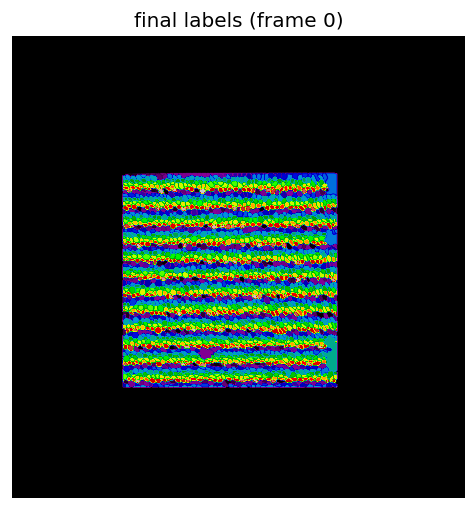

In [44]:
# Cell 8 — צביעה למסכות סופיות (+ סימון מחוץ ל-ROI כ־−1) + בדיקת דגימות
from tqdm import tqdm

T, H, W = seg_work.shape
final_labels = np.full((T, H, W), -1, np.int32)  # ברירת מחדל: −1 לכל הפריימים

grp = track_df.groupby('frame')
painted_frames = 0
for fr, g in tqdm(grp, desc="painting frames"):
    if fr not in labels_dict:
        continue
    lbl = labels_dict[fr]                          # labels שבנינו (כבר בתוך ROI)
    lut = np.zeros(lbl.max() + 1, dtype=np.int32)  # 0=גבול
    arr = g[['label','track_id']].to_numpy()
    lut[arr[:, 0]] = arr[:, 1].astype(np.int32)

    painted = lut[lbl]                             # ממפה label→track_id
    # צובעים **רק** בתוך ה-ROI; מחוץ ל-ROI נשאר −1
    final_labels[fr, valid_roi] = painted[valid_roi]
    painted_frames += 1

print(f"✅ painted {painted_frames} frames out of {len(labels_dict)} labeled good frames")

# בדיקה זריזה על פריים דוגמה
k = good_idx[0]
uniq = np.unique(final_labels[k][final_labels[k] > 0])
print(f"frame {k}: {uniq.size} unique track IDs (>0) in final_labels")
plt.figure(figsize=(5,5), dpi=120)
plt.imshow(final_labels[k] % 200, cmap='nipy_spectral'); plt.title(f"final labels (frame {k})"); plt.axis('off')

# --- בדיקת נקודה: עבור עד 5 דגימות — האם ה-ID במסכה הסופית שווה ל-track_id? ---
# חשוב: בודקים רק פיקסלים **בתוך ה-ROI** (מחוץ ל-ROI זה −1 ולכן לא רלוונטי)
dfk = track_df[track_df.frame == k]
sample_df = dfk.sample(min(5, len(dfk)), random_state=0)

ok = True
for _, r in sample_df.iterrows():
    yy, xx = int(round(r['y'])), int(round(r['x']))
    if 0 <= yy < H and 0 <= xx < W and valid_roi[yy, xx]:
        got = int(final_labels[k, yy, xx])
        want = int(r['track_id'])
        if got != want:
            ok = False
            print("⚠️ mismatch at (y,x)=", (yy, xx),
                  "| final:", got, "| track_id:", want)
    else:
        # מחוץ לתמונה או מחוץ ל-ROI – לא בודקים (זה צפוי להיות −1)
        pass

print("sample check:", "OK" if ok else "MISMATCHES FOUND")


# תא 8.1: החזרת התוויות לגודל המקורי (1932×1932) לשם השוואה עם הגראונד תרות׳

In [46]:
# === Cell 8.1 — Unshift back to original size (1932x1932) for GT comparison ===
from scipy.ndimage import shift as nd_shift

# נוודא שיש לנו את המידע מהתא 4:
# shifts_rc  shape (T,2)  ;  pad_top/bottom/left/right ;  ORIG_H/ORIG_W
assert 'shifts_rc' in globals(), "shifts_rc missing (run Cell 4 first)"
assert final_labels.shape[0] == T, "final_labels must be built already (Cell 8)"
# final_labels בגודל אחרי-padding; נחזיר לגודל המקורי:
final_labels_orig = np.full((T, ORIG_H, ORIG_W), -1, np.int32)

for t in tqdm(range(T), desc="unshift to original"):
    dr_t, dc_t = shifts_rc[t]       # זה ה-shift שיישמנו קודם
    inv = nd_shift(final_labels[t], (-dr_t, -dc_t), order=0, mode='constant', cval=-1)
    # חיתוך חלון המקור מתוך הקנבס המרופד:
    r0, r1 = pad_top, pad_top + ORIG_H
    c0, c1 = pad_left, pad_left + ORIG_W
    final_labels_orig[t] = inv[r0:r1, c0:c1]

print("final_labels_orig shape:", final_labels_orig.shape, "| dtype:", final_labels_orig.dtype)



# === בדיקת “פגיעות/החטאות” מלאה אחרי שהחזרנו ל-1932x1932 ===
# נבדוק עבור פריים k (אפשר להחליף k או להריץ בלולאה על כמה פריימים)

k = good_idx[0]  # בחר פריים לבדיקה
dfk = track_df[track_df.frame == k].copy()

# 1) קואורדינטות הצנטרואיד במרחב drift+pad (כפי שב- track_df)
y_d = dfk['y'].to_numpy(dtype=float)
x_d = dfk['x'].to_numpy(dtype=float)

# 2) ממפים בחזרה לקואורדינטות המקוריות:
#    (a) משחזרים shift הפוך לאותו פריים,
#    (b) מסירים את ה-padding כדי להגיע לחלון המקורי 1932x1932.
dr_k, dc_k = shifts_rc[k]  # rows, cols לשיפט שבוצע על הפריים k
y_o = np.rint(y_d - dr_k - pad_top).astype(int)
x_o = np.rint(x_d - dc_k - pad_left).astype(int)

# 3) גבולות
y_o = np.clip(y_o, 0, ORIG_H-1)
x_o = np.clip(x_o, 0, ORIG_W-1)

# 4) חיווי
pred_ids = final_labels_orig[k, y_o, x_o]
want_ids = dfk['track_id'].astype(int).to_numpy()  # חשוב: numpy, לא Series

mism_idx = np.where(pred_ids != want_ids)[0]
print(f"[full check @ frame {k}] tested {len(dfk)} points | mismatches = {mism_idx.size}")

# הדפס עד 5 דוגמאות
for i in mism_idx[:5]:
    print("  mismatch at (y,x)=", (int(y_o[i]), int(x_o[i])),
          "| final:", int(pred_ids[i]), "| track_id:", int(want_ids[i]))


unshift to original: 100%|██████████| 100/100 [00:16<00:00,  6.09it/s]

final_labels_orig shape: (100, 1932, 1932) | dtype: int32
[full check @ frame 0] tested 2487 points | mismatches = 0


In [47]:
# בדיקה על כמה פריימים (למשל 10 הראשונים ב-good_idx)
subset = good_idx[:10]
total_pts = 0
total_mism = 0

for k in subset:
    dfk = track_df[track_df.frame == k]
    if dfk.empty:
        continue
    y_d = dfk['y'].to_numpy(dtype=float)
    x_d = dfk['x'].to_numpy(dtype=float)
    dr_k, dc_k = shifts_rc[k]
    y_o = np.rint(y_d - dr_k - pad_top).astype(int)
    x_o = np.rint(x_d - dc_k - pad_left).astype(int)
    y_o = np.clip(y_o, 0, ORIG_H-1)
    x_o = np.clip(x_o, 0, ORIG_W-1)

    pred_ids = final_labels_orig[k, y_o, x_o]
    want_ids = dfk['track_id'].astype(int).to_numpy()

    mism = np.count_nonzero(pred_ids != want_ids)
    total_pts  += len(dfk)
    total_mism += mism
    print(f"frame {k}: points={len(dfk)} | mismatches={mism}")

print(f"== summary on {len(subset)} frames: points={total_pts} | mismatches={total_mism} ==")


frame 0: points=2487 | mismatches=0
frame 1: points=2465 | mismatches=0
frame 2: points=2476 | mismatches=0
frame 3: points=2450 | mismatches=0
frame 4: points=2486 | mismatches=0
frame 5: points=2455 | mismatches=0
frame 6: points=2471 | mismatches=0
frame 7: points=2434 | mismatches=0
frame 8: points=2470 | mismatches=0
frame 9: points=2431 | mismatches=0
== summary on 10 frames: points=24625 | mismatches=0 ==


# Cell 8.2 - export tif original size

wrote /Users/idanaviv/Downloads/final_project/implementation/DATA/final_labels_rgb.tif | shape: (100, 1932, 1932, 3)
wrote /Users/idanaviv/Downloads/final_project/implementation/DATA/final_labels_rgb_half.tif | shape: (100, 966, 966, 3)


Text(0.5, 1.0, 'RGB @ frame 0')

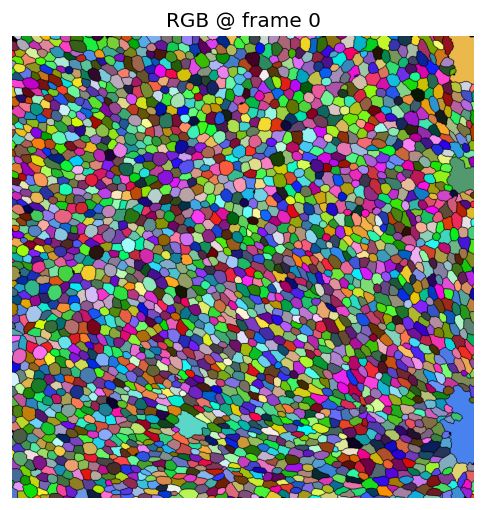

In [49]:
# === Cell 8.2 — Export exactly at original size (and optional half) ===
import numpy as np, tifffile, matplotlib.pyplot as plt

# טבלת צבעים דטרמיניסטית ל-IDs (0=רקע)
rng = np.random.default_rng(0)
MAX_ID = int(max(final_labels_orig.max(), 0))
lut = rng.integers(0, 255, size=(MAX_ID+1, 3), dtype=np.uint8)
lut[0] = 0  # רקע שחור

# build RGB stack @ original size
rgb_full = []
for t in range(T):
    lab = final_labels_orig[t].astype(np.int64)
    lab = np.where(lab < 0, 0, lab)     # -1 → 0 לרקע
    rgb_full.append(lut[lab])           # (H,W,3) uint8
rgb_full = np.stack(rgb_full, axis=0)   # (T,H,W,3)

OUT_FULL = DATA_DIR / "final_labels_rgb.tif"
tifffile.imwrite(OUT_FULL, rgb_full, photometric='rgb')
print("wrote", OUT_FULL, "| shape:", rgb_full.shape)

# (אופציונלי) גם half-res — אם תרצה קובץ קטן לתצוגה
rgb_half = rgb_full[:, ::2, ::2, :]
OUT_HALF = DATA_DIR / "final_labels_rgb_half.tif"
tifffile.imwrite(OUT_HALF, rgb_half, photometric='rgb')
print("wrote", OUT_HALF, "| shape:", rgb_half.shape)

# תצוגת דוגמה
k = good_idx[0]
plt.figure(figsize=(5,5), dpi=120); plt.imshow(rgb_full[k]); plt.axis('off'); plt.title(f"RGB @ frame {k}")


# cell 9

In [51]:
# === Cell 9 — save both spaces and prep labels_list ===
OUT_NPZ = DATA_DIR / "final_labels_both.npz"

# ודא טיפוס
final_labels      = final_labels.astype(np.int32, copy=False)       # drift+pad
final_labels_orig = final_labels_orig.astype(np.int32, copy=False)  # back to 1932x1932

np.savez_compressed(OUT_NPZ,
                    final_labels=final_labels,
                    final_labels_orig=final_labels_orig)
print(f"saved {OUT_NPZ}")
print("  drift+pad:", final_labels.shape, final_labels.dtype)
print("  original :", final_labels_orig.shape, final_labels_orig.dtype)

# נעדיף לעבוד מול הגרסה המקורית להמשך (השוואות, תצוגה קלה)
labels_list = [final_labels_orig[t] for t in range(T)]
print(f"labels_list ready: {len(labels_list)} frames; each {labels_list[0].shape}, dtype={labels_list[0].dtype}")

# דיאגנוסטיקה קטנה (על המרחב המקורי)
k = good_idx[0]
vals, cnts = np.unique(final_labels_orig[k], return_counts=True)
print(f"frame {k} (orig) value histogram (sample):",
      dict(zip(vals[:6], cnts[:6])), "... total px:", cnts.sum())


saved /Users/idanaviv/Downloads/final_project/implementation/DATA/final_labels_both.npz
  drift+pad: (100, 4168, 4086) int32
  original : (100, 1932, 1932) int32
labels_list ready: 100 frames; each (1932, 1932), dtype=int32
frame 0 (orig) value histogram (sample): {0: 486096, 1: 301, 2: 939, 3: 871, 4: 518, 5: 457} ... total px: 3732624


# cell 10

In [53]:
# === Cell 10b — dot video in ORIGINAL space (1932x1932) ===
import imageio
from skimage.draw import disk
import numpy as np

OUT_MP4_ORIG = DATA_DIR / "tracks_dots_orig.mp4"
SCALE        = 1  # אפשר 2 להקטנה
H0, W0       = ORIG_H, ORIG_W

def id2rgb_uint8(tid: int):
    rng = np.random.default_rng(int(tid))
    return tuple(int(v) for v in rng.integers(64, 256, size=3))

def ensure_even(frame_rgb: np.ndarray) -> np.ndarray:
    h, w = frame_rgb.shape[:2]
    pad_h = h % 2
    pad_w = w % 2
    if pad_h or pad_w:
        frame_rgb = np.pad(frame_rgb,
                           ((0, pad_h), (0, pad_w), (0, 0)),
                           mode='edge')
    return frame_rgb

by_frame = {fr: g for fr, g in track_df.groupby('frame')}
writer = imageio.get_writer(str(OUT_MP4_ORIG),
                            fps=6, codec="libx264",
                            quality=6, macro_block_size=1)

for fr in tqdm(range(T), desc="dot video (orig)"):
    base = (seg_full[fr] > 0).astype(np.uint8) * 255    # במרחב המקורי
    frame_rgb = np.stack([base, base, base], axis=-1)

    g = by_frame.get(fr, None)
    if g is not None and len(g):
        # ממפים drift+pad → orig
        y_d = g['y'].to_numpy(dtype=float)
        x_d = g['x'].to_numpy(dtype=float)
        dr, dc = shifts_rc[fr]
        ys = np.rint(y_d - dr - pad_top).astype(int)
        xs = np.rint(x_d - dc - pad_left).astype(int)
        ys = np.clip(ys, 0, H0-1)
        xs = np.clip(xs, 0, W0-1)
        tids = g['track_id'].astype(int).to_numpy()

        for (yy, xx, tid) in zip(ys, xs, tids):
            rr, cc = disk((yy, xx), max(4, DOT_RAD), shape=base.shape)
            frame_rgb[rr, cc] = id2rgb_uint8(tid)

    frame_rgb = ensure_even(frame_rgb)
    writer.append_data(frame_rgb)

writer.close()
print("saved", OUT_MP4_ORIG)


dot video (orig): 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


saved /Users/idanaviv/Downloads/final_project/implementation/DATA/tracks_dots_orig.mp4


# tiff file - צפייה נוחה

In [55]:
# === Save small RGB preview (half-res) from final labels (choose space) ===
from pathlib import Path
import numpy as np, tifffile
from tqdm.auto import tqdm

DATA_DIR = Path.cwd() / "DATA"
OUT_RGB  = DATA_DIR / "final_labels_rgb_half.tif"
SCALE    = 2           # חצי רזולוציה
SPACE    = 'orig'      # 'orig' (1932x1932) להשוואה ל-GT, או 'drift' (drift+pad)

# --- load labels from NPZ if not in memory ---
try:
    labels  # noqa
except NameError:
    arr = np.load(DATA_DIR / "final_labels_both.npz")
    labels = arr["final_labels_orig" if SPACE=='orig' else "final_labels"]

T, H, W = labels.shape
H2, W2  = H // SCALE, W // SCALE

# downsample (nearest) ו-clip לגודל מתחלק
lab_ds = labels[:, :H2*SCALE, :W2*SCALE][:, ::SCALE, ::SCALE].copy()
lab_ds[lab_ds < 0] = 0  # לא-טוב → שחור

max_id = int(lab_ds.max())
# LUT צבעים דטרמיניסטי
lut_rgb = np.zeros((max_id + 1, 3), dtype=np.uint8)
if max_id > 0:
    rngs = [np.random.default_rng(i) for i in range(max_id + 1)]
    for tid in range(1, max_id + 1):
        lut_rgb[tid] = rngs[tid].integers(0, 256, size=3, dtype=np.uint8)

with tifffile.TiffWriter(str(OUT_RGB), bigtiff=True) as tw:
    for t in tqdm(range(T), desc=f"write half-res RGB [{SPACE}]"):
        lab = lab_ds[t]
        rgb = np.zeros((H2, W2, 3), dtype=np.uint8)
        m = lab > 0
        rgb[m] = lut_rgb[lab[m]]
        tw.write(rgb, photometric="rgb", compression="zlib")

print("saved:", OUT_RGB, "| shape:", (T, H2, W2))


write half-res RGB [orig]:   0%|          | 0/100 [00:00<?, ?it/s]

saved: /Users/idanaviv/Downloads/final_project/implementation/DATA/final_labels_rgb_half.tif | shape: (100, 966, 966)


In [56]:
# === Cell A — save labels-as-IDs TIF (no RGB) ===
from pathlib import Path
import numpy as np, tifffile
from tqdm.auto import tqdm

DATA_DIR = Path.cwd() / "DATA"
NPZ_BOTH = DATA_DIR / "final_labels_both.npz"   # כפי שנשמר במחברת המעקב
SPACE    = 'orig'   # 'orig' ← 1932x1932; או 'drift' ← drift+pad
OUT_TIF  = DATA_DIR / (f"final_labels_ids_{SPACE}.tif")

# טוען את ה-labels אם לא בזכרון
try:
    labels  # noqa
except NameError:
    arr = np.load(NPZ_BOTH)
    labels = arr["final_labels_orig" if SPACE=='orig' else "final_labels"]

# שלילה → 0 (שחור), כדי לא לשבור ויזואליזציה/מדדים
lab = labels.copy()
lab[lab < 0] = 0

T, H, W = lab.shape
max_id  = int(lab.max())
# בוחר dtype חסכוני אבל מספיק
if max_id <= 65535:
    lab_dtype = np.uint16
elif max_id <= 4294967295:
    lab_dtype = np.uint32
else:
    lab_dtype = np.uint64  # נדיר מאוד

print(f"writing {OUT_TIF.name} | shape={lab.shape} | max_id={max_id} | dtype={lab_dtype.__name__}")

with tifffile.TiffWriter(str(OUT_TIF), bigtiff=True) as tw:
    for t in tqdm(range(T), desc=f"write IDs [{SPACE}]"):
        plane = lab[t].astype(lab_dtype, copy=False)
        tw.write(
            plane,
            photometric="minisblack",
            compression="zlib",      # או None אם תרצה raw
            contiguous=False
        )

print("saved:", OUT_TIF)


writing final_labels_ids_orig.tif | shape=(100, 1932, 1932) | max_id=5824 | dtype=uint16


write IDs [orig]:   0%|          | 0/100 [00:00<?, ?it/s]

saved: /Users/idanaviv/Downloads/final_project/implementation/DATA/final_labels_ids_orig.tif


In [57]:
vals, cnts = np.unique(final_labels[0], return_counts=True)
print(dict(zip(vals[:20], cnts[:20])))  # 20 הראשונים
print("מס' תאים (ids>0):", (vals>0).sum())

{0: 13783920, 1: 301, 2: 939, 3: 871, 4: 518, 5: 457, 6: 824, 7: 869, 8: 2508, 9: 122, 10: 653, 11: 1476, 12: 283, 13: 718, 14: 447, 15: 1614, 16: 1228, 17: 1076, 18: 1010, 19: 1445}
מס' תאים (ids>0): 2487


In [58]:
# === Cell 1: Load labels (orig space) and optional class map from NPZ ===
import numpy as np

NPZ_PATH = DATA_DIR / "final_labels_both.npz"
data = np.load(NPZ_PATH, allow_pickle=True)
print("[keys]", data.files)

# נעדיף סטאק שכבר צבוע ב-IDs גלובליים ובמרחב המקורי
LBL_KEYS_PREFERRED = [
    "final_labels_orig", "painted_labels_orig", "labels_orig",
    "final_labels_in_original_space", "labels_in_original_space"
]
LBL_KEYS_FALLBACK = [
    "final_labels_common", "painted_labels_common", "labels_common",
    "final_labels", "painted_labels", "labels"
]

labels_stack = None
for k in LBL_KEYS_PREFERRED + LBL_KEYS_FALLBACK:
    if k in data.files:
        labels_stack = data[k]
        print(f"[info] using labels from '{k}' with shape {labels_stack.shape} (T,H,W)")
        break

if labels_stack is None:
    raise RuntimeError("לא נמצא סטאק תוויות ב-NPZ. בדוק את שמות המפתחות ב-[keys] למעלה.")

# מיפוי מחלקה (לא חובה)
CLS_KEYS = ["track_classes", "class_by_id", "id_to_cls", "final_id_to_class", "track_cls"]
cls_map = None
for k in CLS_KEYS:
    if k in data.files:
        try:
            maybe = data[k].item()
            if isinstance(maybe, dict):
                cls_map = {int(k2): str(v2) for k2, v2 in maybe.items()}
                print(f"[info] found class map in '{k}' with {len(cls_map)} entries")
                break
        except Exception:
            pass

# הצצה לתוויות החיוביות בפריים הראשון (גלובליות)
pos = labels_stack[0] > 0
sample_uniques = np.unique(labels_stack[0][pos])[:10]
print("[sanity] sample unique positive IDs in frame 0:", sample_uniques if sample_uniques.size else "none")


[keys] ['final_labels', 'final_labels_orig']
[info] using labels from 'final_labels_orig' with shape (100, 1932, 1932) (T,H,W)
[sanity] sample unique positive IDs in frame 0: [ 1  2  3  4  5  6  7  8  9 10]


In [59]:
# === Cell 2: Per-frame stats with robust neighbors (touching or radius fallback) ===
import numpy as np
import pandas as pd
from skimage.measure import regionprops_table
from scipy.spatial import cKDTree
from tqdm import trange

# פרמטרים לשכנים
NEIGH_MIN_MEAN_DEG = 0.2    # אם הממוצע קטן מזה — נעבור לפאלבק רדיוס
R_MEAN_PIX_GUESS    = 22.5  # אומדן רדיוס (פיקסלים) אם לא יציב מה-areas
KAPPA_FIXED         = 2.4    # רדיוס שכנים = KAPPA_FIXED * r_mean
RADIUS_FLOOR_PIX    = 40.0   # רצפה לרדיוס בפיקסלים
RETRY_MULT          = 1.25   # אם עדיין דליל — נגדיל רדיוס טיפה
MAX_RETRIES         = 2
TOUCH_LEN_MIN = 3   # כמה פיקסלים לפחות של מגע גבול כדי להיחשב שכנים (נסה 3; אפשר 2–5)


DEFAULT_CLASS = "support"    # אם אין cls_map

def adjacency_touching(L, min_len=TOUCH_LEN_MIN):
    """
    מחזיר מילון: id -> set(ids) של שכנים שנוגעים (4-neigh) עם סף אורך מגע מינימלי.
    מתעלם מ-0/-1. נספר פיקסלים של מגע אופקי ואנכי, ומעדכנים רק אם הסכום >= min_len.
    """
    counter = {}

    def _accumulate(A, B):
        # A,B הם שתי תת-תמונות מיושרות (למשל L[:,:-1] מול L[:,1:])
        m = (A > 0) & (B > 0) & (A != B)
        if not m.any():
            return
        a = A[m].ravel().astype(np.int64)
        b = B[m].ravel().astype(np.int64)
        lo = np.minimum(a, b)
        hi = np.maximum(a, b)
        # אורזים לזוג ייחודי כ-int64 כדי לאחד חזרות ולספור
        packed = (lo << 32) + hi
        uniq, cnts = np.unique(packed, return_counts=True)
        los = (uniq >> 32).astype(np.int64)
        his = (uniq & 0xffffffff).astype(np.int64)
        for i, j, c in zip(los, his, cnts.astype(int)):
            counter[(int(i), int(j))] = counter.get((int(i), int(j)), 0) + int(c)

    # מגע אופקי (ימינה) ואנכי (למטה)
    _accumulate(L[:, :-1], L[:,  1:])
    _accumulate(L[:-1, :], L[1:,  :])

    # בונים גרף שכנות רק לזוגות עם מגע מספיק ארוך
    neigh = {}
    for (i, j), c in counter.items():
        if c >= int(min_len):
            neigh.setdefault(i, set()).add(j)
            neigh.setdefault(j, set()).add(i)
    return neigh

def neighbors_radius_fallback(df_frame):
    """
    שכני רדיוס סביב צנטרואידים, ברדיוס שנגזר מה-areas (או אומדן קבוע).
    מחזיר רשימת שכנים (track_id-ים גלובליים) לכל שורה.
    """
    n = len(df_frame)
    if n == 0:
        return [[] for _ in range(0)]
    pts = df_frame[['y','x']].to_numpy(dtype=float)
    tree = cKDTree(pts)

    # r_mean לפי שטחים (אם נופל – נשתמש באומדן)
    areas = df_frame['area'].to_numpy(dtype=float)
    r_from_area = float(np.mean(np.sqrt(np.maximum(areas, 1.0)/np.pi))) if n > 0 else R_MEAN_PIX_GUESS
    r_mean = max(r_from_area, R_MEAN_PIX_GUESS)
    radius = max(KAPPA_FIXED * r_mean, RADIUS_FLOOR_PIX)

    tries = 0
    while True:
        idxs = tree.query_ball_tree(tree, r=float(radius))
        neighs = [
            [int(df_frame['track_id'].iat[j]) for j in js if j != i]
            for i, js in enumerate(idxs)
        ]
        mean_deg = float(np.mean([len(v) for v in neighs])) if n > 0 else 0.0
        if (mean_deg < NEIGH_MIN_MEAN_DEG) and (tries < MAX_RETRIES):
            radius *= RETRY_MULT
            tries += 1
            continue
        break
    return neighs

rows = []
T = int(labels_stack.shape[0])

for t in trange(T, desc="per-frame stats"):
    L = labels_stack[t]

    # regionprops_table ישירות על תמונת תוויות עם IDs גלובליים במרחב המקורי
    props = regionprops_table(
        L,
        properties=("label", "area", "centroid", "bbox", "perimeter")
    )
    df = pd.DataFrame(props)

    # שמות עמודות
    df = df.rename(columns={
        "label":    "track_id",
        "centroid-0": "y",
        "centroid-1": "x",
        "bbox-0":   "bbox_y0",
        "bbox-1":   "bbox_x0",
        "bbox-2":   "bbox_y1",
        "bbox-3":   "bbox_x1",
    })

    # circularity = 4*pi*A / P^2 (נזהר מ-P=0)
    P = np.clip(df["perimeter"].astype(float).to_numpy(), 1e-6, None)
    A = df["area"].astype(float).to_numpy()
    df["circularity"] = (4.0 * np.pi * A) / (P * P)

    # שכנות לפי נגיעה (אם יוצא דליל מדי — פאלבק רדיוס)
    touch = adjacency_touching(L)
    neighbors_touch = df["track_id"].astype(int).map(lambda k: sorted(touch.get(int(k), set())))
    mean_deg_touch = float(np.mean([len(v) for v in neighbors_touch])) if len(df) else 0.0

    if mean_deg_touch >= NEIGH_MIN_MEAN_DEG:
        df["neighbors"] = neighbors_touch
        df["degree"] = neighbors_touch.map(len)
        used_mode = "touching"
    else:
        neighs = neighbors_radius_fallback(df)
        df["neighbors"] = neighs
        df["degree"] = [len(v) for v in neighs]
        used_mode = "radius-fallback"

    # מחלקה
    if 'cls_map' in globals() and (cls_map is not None):
        df["cls"] = df["track_id"].astype(int).map(lambda k: cls_map.get(int(k), DEFAULT_CLASS))
    else:
        df["cls"] = DEFAULT_CLASS

    df["frame"] = t

    # סדר סופי
    cols = ["frame", "track_id", "area", "perimeter", "circularity",
            "y", "x", "bbox_y0", "bbox_x0", "bbox_y1", "bbox_x1",
            "degree", "neighbors", "cls"]
    df = df[cols]

    rows.append(df)

out = pd.concat(rows, ignore_index=True)

# שמירה
csv_path = (NPZ_PATH.parent / "per_frame_stats.csv")
out.to_csv(csv_path, index=False)
print(f"[done] saved {csv_path.name} with shape {out.shape}")

# דיאגנוסטיקה מהירה: בדיקה שה-(y,x) תואם ל-track_id בפריים הראשון
try:
    row0 = out[out["frame"] == 0].iloc[0]
    r0 = int(round(float(row0["y"])))
    c0 = int(round(float(row0["x"])))
    tid0 = int(row0["track_id"])
    val = int(labels_stack[0, r0, c0])
    print(f"[check] frame=0 at (y,x)=({r0},{c0}) → L = {val} ; expected track_id = {tid0}")
except Exception as e:
    print("[check] skipped (no rows for frame 0 or out-of-bounds).", repr(e))

print("[neighbors] mode used in last frame processed:", used_mode)


per-frame stats: 100%|██████████| 100/100 [00:29<00:00,  3.37it/s]


[done] saved per_frame_stats.csv with shape (223699, 14)
[check] frame=0 at (y,x)=(5,24) → L = 1 ; expected track_id = 1
[neighbors] mode used in last frame processed: radius-fallback


In [60]:
# === FILE_NAME2 (fixed) — per_track_stats.csv ===
import numpy as np, pandas as pd
from pathlib import Path

DATA_DIR = Path.cwd() / "DATA"
PF_PATHS = [DATA_DIR/"per_frame_stats.csv", Path.cwd()/"per_frame_stats.csv"]

# אם המשתנה לא בזיכרון — נקרא מהדיסק (מהקבצים שנשמרו בתא FILE_NAME1)
if 'perframe_stats' not in globals():
    for p in PF_PATHS:
        if p.exists():
            perframe_stats = pd.read_csv(p)
            print(f"[FILE_NAME2] loaded {p.name} → perframe_stats.shape={perframe_stats.shape}")
            break
    else:
        raise FileNotFoundError("לא נמצא per_frame_stats.csv (בדקתי DATA ו־cwd).")

assert 'track_df' in globals(), "צריך track_df מהשלבים 7/7.6/7C"

# ---- עזר: חישוב אורך מסלול (סכום מרחקים בין-פריימים) ----
def path_length_for_track(df_one: pd.DataFrame) -> float:
    d = df_one.sort_values('frame')
    if len(d) <= 1: return 0.0
    dy = np.diff(d['y'].to_numpy(dtype=float))
    dx = np.diff(d['x'].to_numpy(dtype=float))
    return float(np.sum(np.hypot(dy, dx)))

# ---- עזר: דינמיקת מחלקה + commit ----
def class_dynamics_for_track(df_one: pd.DataFrame):
    cols = [c for c in ['cls_fixed','cls_raw','cls'] if c in df_one.columns]
    d = df_one.sort_values('frame')
    vals = None
    for c in cols:
        if d[c].notna().any():
            vals = d[c].astype(int).to_numpy(); break
    if vals is None: vals = np.full(len(d), 2, dtype=int)

    final_cls_num = int(vals[-1])
    final_cls = 'hair' if final_cls_num==1 else 'support'
    changed = (final_cls_num==1) and (np.min(vals)==2)

    commit_frame = -1
    if 'commit_frame' in d.columns:
        cands = d['commit_frame'].to_numpy()
        cands = cands[np.where(cands >= 0)]
        if cands.size: commit_frame = int(np.max(cands))
    if not changed: commit_frame = -1
    return final_cls, bool(changed), int(commit_frame)

g = track_df.groupby('track_id', sort=True)

basic = g.agg(
    first_frame=('frame','min'),
    last_frame =('frame','max'),
    lifetime   =('frame','nunique'),
    mean_area  =('area','mean'),
    median_area=('area','median')
).reset_index()

frames_list = g['frame'].apply(lambda s: tuple(sorted(set(s.to_list())))).reset_index(name='frames_list')
path_len = g.apply(path_length_for_track, include_groups=False).reset_index(name='path_length')

dyn_rows = []
for tid, df_one in g:
    final_cls, changed, commit_fr = class_dynamics_for_track(df_one)
    dyn_rows.append({'track_id': int(tid),
                     'final_class': final_cls,
                     'type_changed_support_to_hair': changed,
                     'commit_frame': commit_fr})
dyn = pd.DataFrame(dyn_rows)

deg_mean = (perframe_stats.groupby('track_id')['degree']
            .mean().reset_index().rename(columns={'degree':'mean_neighbor_count'}))

tracks_stats = (basic
                .merge(frames_list, on='track_id', how='left')
                .merge(path_len,    on='track_id', how='left')
                .merge(dyn,         on='track_id', how='left')
                .merge(deg_mean,    on='track_id', how='left')
                .fillna({'mean_neighbor_count': 0.0}))

OUT_CSV2 = DATA_DIR / "per_track_stats.csv"
tracks_stats.to_csv(OUT_CSV2, index=False)
print(f"[FILE_NAME2] wrote {OUT_CSV2.name} | tracks={len(tracks_stats)}")
display(tracks_stats.head(8))


[FILE_NAME2] loaded per_frame_stats.csv → perframe_stats.shape=(223699, 14)
[FILE_NAME2] wrote per_track_stats.csv | tracks=4561


,track_id,first_frame,last_frame,lifetime,mean_area,median_area,frames_list,path_length,final_class,type_changed_support_to_hair,commit_frame,mean_neighbor_count
0,1,0,11,12,531.166667,613.5,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)",78.883014,support,False,-1,4.833333
1,2,0,11,12,903.333333,1027.5,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11)",58.812850,support,False,-1,5.500000
2,3,0,20,21,844.761905,1030.0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",101.839516,support,False,-1,5.809524
3,4,0,30,30,660.533333,753.0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",155.079026,support,False,-1,6.433333
4,5,0,39,40,942.550000,1081.0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",146.011185,support,False,-1,5.375000
5,6,0,63,60,841.333333,829.5,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",194.545402,support,False,-1,5.300000
6,7,0,75,72,989.972222,1057.0,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",235.401188,support,False,-1,4.986111
7,8,0,99,96,1748.270833,1987.5,"(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",288.675468,support,False,-1,4.364583


In [61]:
# === Division detection (parent -> two daughters) — v2.6 SOFT-OVERLAP + FRAGMENT MERGE ===
# חפיפה רכה (EDT) + איחוד שברי־בנות צמודים לשתי המובילות → פחות third_big/frac_fail.
# תואם I/O: מצפה ל-labels_stack, כותב DATA/events_division.csv

import numpy as np, pandas as pd
from pathlib import Path
from scipy import ndimage as ndi

assert 'labels_stack' in globals(), "צריך labels_stack בזיכרון"
assert labels_stack.ndim == 3, "labels_stack חייב להיות בצורה (T,H,W)"

DATA_DIR = Path.cwd() / "DATA"
OUT_DIV  = DATA_DIR / "events_division.csv"

# ----- ספים (שומרים על הקשיחות שהייתה, עם התאמות עדינות) -----
MIN_FRAC_CHILD        = 0.22
MIN_COVER_PARENT      = 0.80
MAX_PARENT_RESID      = 0.06
MAX_THIRD_FRAC        = 0.05     # יישמר הודות לאיחוד השברים
MIN_TOUCH_LEN         = 3        # היה 4
CONTACT_RADIUS        = 4        # היה 2
MAX_AREA_ERR          = 0.35     # היה 0.20 — רופף מעט כדי לא להפיל חלוקות אמיתיות
K_PERSIST             = 2
DEDUP_WINDOW          = 2
REQUIRE_TOP2_BY_CHILD = True

# סינון קצה-רקמה
EDGE_BRIDGE_PX = 3
DIST_Q = 0.25
TISSUE_EDGE_MIN_DIST_PARENT = 10
TISSUE_EDGE_MIN_DIST_CHILD  = 6
CHECK_CHILD_TISSUE_EDGE     = True

# גאומטריה
SEP_ANGLE_MIN_DEG     = 80
MIN_RAD_FRAC_FROM_CTR = 0.22
MIN_CHILDREN_SEP_FRAC = 0.55

# ביולוגיה: רק תא תומך יכול להתחלק (אם יש מידע)
ONLY_IF_SUPPORT   = True
SUPPORT_CLASS_ID  = 2

# --- פרמטרי "חפיפה רכה" ואיחוד שברים ---
SHIFT_TOL_PX          = 3        # סבילות היסט בין פריימים בחישוב החפיפה (EDT)
MERGE_CHILD_MAX_FRAC  = 0.15     # נספח שברי-בנות עד גודל זה לאחת המובילות
MERGE_BY_CENTROID_BIAS= 0.7      # אם אין מגע: נצמיד לבת הקרובה אם d_min <= 0.7*d_max
TOPK_FALLBACK         = 3
FALLBACK_COVER        = max(0.70, MIN_COVER_PARENT - 0.08)
DEBUG = True

# ---------- עזרים ----------
def adjacency_touching_radius(L, min_len=MIN_TOUCH_LEN, radius=CONTACT_RADIUS):
    """מגע בין מזהים שונים במרחק צ'בישב <= radius (חיתוכים מסונכרנים)."""
    H, W = L.shape
    min_len = int(min_len); radius = int(radius)
    if radius <= 0: return {}
    counter = {}
    for dy in range(-radius, radius+1):
        for dx in range(-radius, radius+1):
            if dy == 0 and dx == 0: continue
            if abs(dy) >= H or abs(dx) >= W: continue
            # חיתוך מסונכרן
            if dy >= 0: y0a, y1a, y0b, y1b = 0, H-dy, dy, H
            else:       y0a, y1a, y0b, y1b = -dy, H, 0, H+dy
            if dx >= 0: x0a, x1a, x0b, x1b = 0, W-dx, dx, W
            else:       x0a, x1a, x0b, x1b = -dx, W, 0, W+dx
            A = L[y0a:y1a, x0a:x1a]
            B = L[y0b:y1b, x0b:x1b]
            m = (A > 0) & (B > 0) & (A != B)
            if not m.any(): continue
            a = A[m].ravel().astype(np.int64)
            b = B[m].ravel().astype(np.int64)
            lo = np.minimum(a, b); hi = np.maximum(a, b)
            packed = (lo << 32) + hi
            uniq, cnts = np.unique(packed, return_counts=True)
            los = (uniq >> 32).astype(np.int64); his = (uniq & 0xffffffff).astype(np.int64)
            for i, j, c in zip(los, his, cnts.astype(int)):
                counter[(int(i), int(j))] = counter.get((int(i), int(j)), 0) + c
    # מסנן לפי min_len ושומר סימטריה
    thr = int(min_len)
    touch_len = {}
    for (i, j), c in counter.items():
        if c >= thr:
            touch_len[(i, j)] = c
            touch_len[(j, i)] = c
    return touch_len

def _angle_deg(p, a, b):
    vy1, vx1 = a[0]-p[0], a[1]-p[1]
    vy2, vx2 = b[0]-p[0], b[1]-p[1]
    v1 = np.array([vy1, vx1], float); v2 = np.array([vy2, vx2], float)
    n1 = np.linalg.norm(v1); n2 = np.linalg.norm(v2)
    if n1 == 0 or n2 == 0: return 0.0
    cos_t = float(np.clip(np.dot(v1, v2)/(n1*n2), -1.0, 1.0))
    return float(np.degrees(np.arccos(cos_t)))

def soft_parent_map(L0, max_dist=SHIFT_TOL_PX):
    """לכל פיקסל בפריים t, הורה קרוב (EDT) עד רדיוס max_dist; רחוקים → 0."""
    mask = (L0 > 0)
    dt, (iy, ix) = ndi.distance_transform_edt(~mask, return_indices=True)
    near_labels = L0[iy, ix]
    if max_dist is not None and max_dist > 0:
        near_labels = near_labels.copy()
        near_labels[dt > float(max_dist)] = 0
    return near_labels

# ---------- חישובי קבע ----------
T, H, W = map(int, labels_stack.shape)

# מסכת רקמה מגושרת + EDT
edt_cache = []
for t in range(T):
    raw = labels_stack[t] > 0
    tissue = ndi.binary_fill_holes(raw)
    if EDGE_BRIDGE_PX > 0:
        tissue = ndi.binary_dilation(tissue, iterations=EDGE_BRIDGE_PX)
        tissue = ndi.binary_fill_holes(tissue)
        tissue = ndi.binary_erosion(tissue, iterations=EDGE_BRIDGE_PX)
    edt_cache.append(ndi.distance_transform_edt(tissue))

# מטא־מידע לפריים
ids_present = [set(np.unique(labels_stack[t])) for t in range(T)]
areas_cache, centroids_cache = [], []
for t in range(T):
    L = labels_stack[t]
    ids, counts = np.unique(L[L > 0], return_counts=True)
    areas_cache.append(dict(zip(ids.tolist(), counts.tolist())))
    com = ndi.center_of_mass(np.ones_like(L, dtype=np.uint8), labels=L, index=ids) if len(ids) else []
    centroids_cache.append({int(i):(float(y),float(x)) for i,(y,x) in zip(ids, com)})

def area_of(t, obj_id):     return float(areas_cache[t].get(int(obj_id), 0.0))
def centroid_of(t, obj_id): return centroids_cache[t].get(int(obj_id), (float('nan'), float('nan')))
def dist_to_edge(t, obj_id, q=DIST_Q):
    L = labels_stack[t]; dt = edt_cache[t]; m = (L == int(obj_id))
    return float(np.quantile(dt[m], q)) if m.any() else 0.0

def persists_consecutively(t, obj_id, k=K_PERSIST):
    tmax = min(T-1, t + k)
    for tt in range(t+1, tmax+1):
        if int(obj_id) not in ids_present[tt]:
            return False
    return True

# ---------- חפיפה רכה + Top-k ----------
def build_parent_child_intersections(L0, L1, shift_tol=SHIFT_TOL_PX):
    """by_parent[p]->[(ch, frac_on_parent)], by_child[ch]->[(p, frac_on_child)]."""
    L0_soft = soft_parent_map(L0, max_dist=shift_tol)
    m = (L0_soft > 0) & (L1 > 0)
    if not np.any(m):
        return {}, {}, {}, {}
    a = L0_soft[m].astype(np.int64).ravel()
    b = L1[m].astype(np.int64).ravel()
    packed = (a << 32) + b
    uniq, cnts = np.unique(packed, return_counts=True)
    id0s = (uniq >> 32).astype(np.int64)
    id1s = (uniq & 0xffffffff).astype(np.int64)

    ids0, counts0 = np.unique(L0[L0 > 0], return_counts=True)
    ids1, counts1 = np.unique(L1[L1 > 0], return_counts=True)
    area0 = dict(zip(ids0.tolist(), counts0.tolist()))
    area1 = dict(zip(ids1.tolist(), counts1.tolist()))

    by_parent, by_child = {}, {}
    for p, ch, c in zip(id0s, id1s, cnts.astype(float)):
        A0 = float(area0.get(int(p), 0.0))
        A1 = float(area1.get(int(ch), 0.0))
        if A0 <= 0 or A1 <= 0: continue
        fr_on_parent = min(1.0, c / A0)
        fr_on_child  = min(1.0, c / A1)
        by_parent.setdefault(int(p), []).append((int(ch), fr_on_parent))
        by_child.setdefault(int(ch), []).append((int(p), fr_on_child))
    return by_parent, by_child, area0, area1

def parent_in_topk_for_child(parent_id, child_id, by_child, k=2):
    lst = by_child.get(int(child_id), [])
    if not lst: return False
    lst_sorted = sorted(lst, key=lambda x: x[1], reverse=True)
    topk = [pid for pid,_ in lst_sorted[:k]]
    return int(parent_id) in topk

# ---------- איחוד שברי-בנות אל שתי המובילות ----------
def effective_two_children(t, c1, c2, l_sorted, touch_len,
                           merge_thr=MERGE_CHILD_MAX_FRAC,
                           centroid_bias=MERGE_BY_CENTROID_BIAS):
    """
    מחזיר f1_eff, f2_eff, f3_eff אחרי צירוף שברים קטנים (<=merge_thr) שנוגעים/קרובים ל-c1/c2.
    """
    # בסיס: הפרקציות של שתי המובילות
    f_map = dict(l_sorted)
    f1 = float(f_map.get(int(c1), 0.0))
    f2 = float(f_map.get(int(c2), 0.0))
    leftovers = [(ci, fi) for (ci, fi) in l_sorted if ci not in (c1, c2)]

    merged = set()
    for ci, fi in leftovers:
        if fi > merge_thr:
            continue
        tl1 = int(touch_len.get((ci, c1), 0))
        tl2 = int(touch_len.get((ci, c2), 0))
        if (tl1 > 0) ^ (tl2 > 0):  # מגע עם אחת בלבד
            if tl1 > 0:
                f1 += fi; merged.add(ci)
            else:
                f2 += fi; merged.add(ci)
        elif (tl1 == 0) and (tl2 == 0):
            # אין מגע — נכריע לפי קרבת צנטרואיד אם אחת קרובה משמעותית
            yci, xci = centroid_of(t+1, ci)
            y1, x1 = centroid_of(t+1, c1)
            y2, x2 = centroid_of(t+1, c2)
            if np.isfinite([yci,xci,y1,x1,y2,x2]).all():
                d1 = np.hypot(yci - y1, xci - x1)
                d2 = np.hypot(yci - y2, xci - x2)
                dmin, dmax = (d1, d2) if d1 <= d2 else (d2, d1)
                if dmax > 0 and (dmin <= centroid_bias * dmax):
                    if d1 <= d2:
                        f1 += fi; merged.add(ci)
                    else:
                        f2 += fi; merged.add(ci)
    f3_eff = float(sum(fi for (ci, fi) in leftovers if ci not in merged))
    # כיסוי לא יעלה על 1
    f1 = float(min(1.0, f1))
    f2 = float(min(1.0, f2))
    return f1, f2, f3_eff

# ---------- לולאת זיהוי ----------
rows = []
last_event_by_parent = {}
dbg = dict(total_parents=0, dedup=0, parent_edge=0, few_children=0, frac_fail=0,
           third_big=0, resid_fail=0, no_touch=0, no_persist=0, class_fail=0,
           geom_fail=0, child_edge=0, prev_dup=0, area_cons_fail=0, top2_fail=0,
           top3_rescue=0, merged_fragments=0)

for t in range(0, T-1):
    L0 = labels_stack[t]
    L1 = labels_stack[t+1]

    by_parent, by_child, area0, area1 = build_parent_child_intersections(L0, L1, shift_tol=SHIFT_TOL_PX)
    if not by_parent:
        continue

    touch_len = adjacency_touching_radius(L1, min_len=MIN_TOUCH_LEN, radius=CONTACT_RADIUS)

    for parent, lst in by_parent.items():
        dbg['total_parents'] += 1
        A0 = float(area0.get(int(parent), 0.0))
        if A0 <= 0: continue

        # דופליקציה
        last_t = last_event_by_parent.get(parent, None)
        if last_t is not None and (t - last_t) <= DEDUP_WINDOW:
            dbg['dedup'] += 1; continue

        # קצה־רקמה להורה
        if dist_to_edge(t, parent) < TISSUE_EDGE_MIN_DIST_PARENT:
            dbg['parent_edge'] += 1; continue

        # רק תא תומך?
        if ONLY_IF_SUPPORT and ('track_df' in globals()) and ('cls_fixed' in track_df.columns):
            msk = (track_df['track_id']==parent) & (track_df['frame']==t)
            if msk.any():
                parent_cls = int(track_df.loc[msk, 'cls_fixed'].iloc[0])
                if parent_cls != SUPPORT_CLASS_ID:
                    dbg['class_fail'] += 1; continue

        # לפחות שתי בנות
        l_sorted = sorted(lst, key=lambda x: x[1], reverse=True)
        if len(l_sorted) < 2:
            dbg['few_children'] += 1; continue
        (c1, f1_raw), (c2, f2_raw) = l_sorted[:2]

        # Top-2 לפי כיסוי הילדה
        in2_a = parent_in_topk_for_child(parent, c1, by_child, k=2)
        in2_b = parent_in_topk_for_child(parent, c2, by_child, k=2)
        in2_both = bool(in2_a and in2_b)
        parent_in_top2 = in2_both
        if REQUIRE_TOP2_BY_CHILD and (not in2_both):
            in3_both = parent_in_topk_for_child(parent, c1, by_child, k=TOPK_FALLBACK) and \
                       parent_in_topk_for_child(parent, c2, by_child, k=TOPK_FALLBACK)
            if in3_both:
                dbg['top3_rescue'] += 1
            else:
                dbg['top2_fail'] += 1
                continue

        # איחוד שברי-בנות → פרקציות אפקטיביות
        f1_eff, f2_eff, f3_eff = effective_two_children(
            t, c1, c2, l_sorted, touch_len,
            merge_thr=MERGE_CHILD_MAX_FRAC, centroid_bias=MERGE_BY_CENTROID_BIAS
        )
        if (f1_eff > f1_raw) or (f2_eff > f2_raw):
            dbg['merged_fragments'] += 1

        cover = min(1.0, f1_eff + f2_eff)
        residual = max(0.0, 1.0 - cover)

        # ספי כיסוי/שארית/בת שלישית
        if not (f1_eff >= MIN_FRAC_CHILD and f2_eff >= MIN_FRAC_CHILD and cover >= MIN_COVER_PARENT):
            dbg['frac_fail'] += 1; continue
        if f3_eff > MAX_THIRD_FRAC:
            dbg['third_big'] += 1; continue
        if (not parent_in_top2) and (residual > MAX_PARENT_RESID):
            dbg['resid_fail'] += 1; continue

        # מגע בין שתי הבנות
        tl = int(touch_len.get((c1, c2), 0))
        if tl < MIN_TOUCH_LEN:
            dbg['no_touch'] += 1; continue

        # התמדה רציפה
        if not (persists_consecutively(t+1, c1, k=K_PERSIST) and
                persists_consecutively(t+1, c2, k=K_PERSIST)):
            dbg['no_persist'] += 1; continue

        # גאומטריה
        y0, x0 = centroid_of(t, parent)
        y1, x1 = centroid_of(t+1, c1)
        y2, x2 = centroid_of(t+1, c2)
        if not np.isfinite([y0,x0,y1,x1,y2,x2]).all():
            dbg['geom_fail'] += 1; continue
        r_eq = np.sqrt(max(A0, 1.0)/np.pi)
        d1  = float(np.hypot(y1-y0, x1-x0))
        d2  = float(np.hypot(y2-y0, x2-x0))
        d12 = float(np.hypot(y2-y1, x2-x1))
        ang = _angle_deg((y0,x0), (y1,x1), (y2,x2))
        if (ang < SEP_ANGLE_MIN_DEG) or \
           (d1 < MIN_RAD_FRAC_FROM_CTR*r_eq) or \
           (d2 < MIN_RAD_FRAC_FROM_CTR*r_eq) or \
           (d12 < MIN_CHILDREN_SEP_FRAC*r_eq):
            dbg['geom_fail'] += 1; continue

        # שימור שטח (רופף קצת)
        A1 = float(area1.get(int(c1), 0.0))
        A2 = float(area1.get(int(c2), 0.0))
        area_err = abs((A1 + A2) - A0) / max(A0, 1.0)
        if area_err > MAX_AREA_ERR:
            dbg['area_cons_fail'] += 1; continue

        # קצה־רקמה לילדות
        if CHECK_CHILD_TISSUE_EDGE:
            if dist_to_edge(t+1, c1) < TISSUE_EDGE_MIN_DIST_CHILD or \
               dist_to_edge(t+1, c2) < TISSUE_EDGE_MIN_DIST_CHILD:
                dbg['child_edge'] += 1; continue

        # אירוע עבר את הכל
        rows.append(dict(
            frame=t,
            parent_id=int(parent),
            child_a=int(c1), frac_a=float(f1_eff),
            child_b=int(c2), frac_b=float(f2_eff),
            cover_frac=float(cover),
            parent_remain=float(residual),
            touch_len=int(tl),
            persist_a=True, persist_b=True,
            parent_in_top2=bool(parent_in_top2),
            y_event=float(y0), x_event=float(x0),
            y_child_a=float(y1), x_child_a=float(x1),
            y_child_b=float(y2), x_child_b=float(x2),
            angle_deg=float(ang), r_eq=float(r_eq),
            d1=float(d1), d2=float(d2), d12=float(d12),
            f3=float(f3_eff)
        ))
        last_event_by_parent[parent] = t

# ---------- כתיבה ודיוג ----------
div_df = pd.DataFrame(rows)
OUT_DIV.parent.mkdir(parents=True, exist_ok=True)
div_df.to_csv(OUT_DIV, index=False)
print(f"[division] wrote {OUT_DIV.name} | events={len(div_df)}")
if DEBUG:
    print("[debug] examined parents:", dbg.get('total_parents', 0))
    for k in ['dedup','parent_edge','few_children','frac_fail','third_big',
              'resid_fail','no_touch','no_persist','class_fail','geom_fail',
              'child_edge','prev_dup','area_cons_fail','top2_fail','top3_rescue','merged_fragments']:
        print(f"[debug] {k:>12}: {dbg.get(k,0)}")
display(div_df.head(10))


KeyboardInterrupt: 

In [64]:
# === FILE_NAME4 — Delamination detection (degree/area/circularity trends) ===
import numpy as np, pandas as pd
from pathlib import Path

DATA_DIR = Path.cwd() / "DATA"
OUT_DEL = DATA_DIR/"events_delamination.csv"

# ספים — אפשר לכוונן
ONLY_HAIR          = True   # רלוונטי כשיש cls_fixed=1/2 ב-track_df
W_PRE              = 10     # חלון ממוצע "לפני"
W_POST             = 2      # חלון ממוצע "אחרי"
DEG_DROP_ABS       = 1.5    # ירידה מוחלטת מינימלית בממוצע degree (לפני→אחרי)
DEG_POST_MAX       = 0.5    # ממוצע degree אחרי <= 0.5 (כמעט בלי שכנים)
AREA_DROP_FRAC     = 0.25   # יחס post/prev <= 0.75 (כלומר ירידה >=25%)
CIRC_INC_MIN       = 0.10   # עליה בצירקולריות של >=0.10 (אופציונלי; אם אין עמודה — מתעלמים)
K_VANISH           = 10      # כמה פריימים לכל היותר עד שהמסלול נגמר
MIN_LIFE_BEFORE    = 4      # נדרוש שהמסלול חי לפחות X פריימים לפני האירוע

# --- טעינת per_frame_stats ---
if 'perframe_stats' not in globals():
    for p in [DATA_DIR/"per_frame_stats.csv", Path.cwd()/"per_frame_stats.csv"]:
        if p.exists():
            perframe_stats = pd.read_csv(p)
            print(f"[delam] loaded {p.name} → perframe_stats.shape={perframe_stats.shape}")
            break
    else:
        raise FileNotFoundError("לא נמצא per_frame_stats.csv")

# אינדקס מהיר לקואורדינטות
_pf_xy = (perframe_stats[['track_id','frame','y','x']]
          .dropna(subset=['track_id','frame'])
          .astype({'track_id':int,'frame':int})
          .drop_duplicates(subset=['track_id','frame'])
          .set_index(['track_id','frame']))

def xy_from_pf_or_labels(tid:int, fr:int):
    """(y,x) מתוך per_frame_stats; ואם חסר ויש labels_stack — חישוב מצנטרואיד."""
    key = (int(tid), int(fr))
    if key in _pf_xy.index:
        r = _pf_xy.loc[key]
        return float(r['y']), float(r['x'])
    if 'labels_stack' in globals():
        L = labels_stack[int(fr)] if 0 <= int(fr) < labels_stack.shape[0] else None
        if L is not None:
            m = (L == int(tid))
            if np.any(m):
                ys, xs = np.nonzero(m)
                return float(ys.mean()), float(xs.mean())
    return float('nan'), float('nan')

# נאסוף Timeseries פר-מסלול
need_cols = ['frame','track_id','degree','area']
opt_cols  = [c for c in ['circularity'] if c in perframe_stats.columns]
pf = perframe_stats[need_cols + opt_cols].copy()

# אם יש מחלקה קבועה — נחבר
cls_map_df = None
if 'track_df' in globals() and ('cls_fixed' in track_df.columns):
    cls_map_df = track_df[['track_id','frame','cls_fixed']]
    pf = pf.merge(cls_map_df, on=['track_id','frame'], how='left')

rows = []

for tid, df in pf.groupby('track_id'):
    d = df.sort_values('frame').reset_index(drop=True)
    frames = d['frame'].to_numpy()
    deg    = d['degree'].to_numpy(dtype=float)
    area   = d['area'].to_numpy(dtype=float)
    circ   = d['circularity'].to_numpy(dtype=float) if 'circularity' in d.columns else None
    n = len(d)
    if n < (W_PRE + W_POST + MIN_LIFE_BEFORE): 
        continue

    # Hair-only (אם נדרש)
    if ONLY_HAIR and ('cls_fixed' in d.columns):
        if int(d['cls_fixed'].iloc[-1]) != 1:
            continue

    last_frame = int(frames[-1])

    # נבדוק כל t שמאפשר חלונות לפני/אחרי, וגם מוביל ל"היעלמות" בקרוב
    for idx in range(W_PRE, n - W_POST):
        t = int(frames[idx])
        vanish = (frames[-1] <= t + K_VANISH)
        if not vanish:
            continue
        if (idx < MIN_LIFE_BEFORE):
            continue

        pre  = slice(idx - W_PRE, idx)           # W_PRE פריימים לפני
        post = slice(idx, min(n, idx + W_POST))  # W_POST פריימים אחרי/כולל

        deg_pre  = float(np.mean(deg[pre]))
        deg_post = float(np.mean(deg[post]))

        area_pre  = float(np.median(area[pre]))
        area_post = float(np.median(area[post]))
        area_ratio = area_post / max(area_pre, 1e-6)

        circ_inc = 0.0
        if circ is not None:
            circ_pre  = float(np.median(circ[pre]))
            circ_post = float(np.median(circ[post]))
            circ_inc  = (circ_post - circ_pre)

        cond_deg_drop = (deg_pre - deg_post) >= DEG_DROP_ABS and (deg_post <= DEG_POST_MAX)
        cond_area     = (area_ratio <= (1.0 - AREA_DROP_FRAC))
        cond_circ     = (circ is None) or (circ_inc >= CIRC_INC_MIN)

        if cond_deg_drop and cond_area and cond_circ:
            # --- NEW: קואורדינטות האירוע והפריים האחרון למסלול ---
            y_evt, x_evt = xy_from_pf_or_labels(int(tid), t)
            y_last, x_last = xy_from_pf_or_labels(int(tid), last_frame)

            rows.append(dict(
                track_id=int(tid),
                frame_delam=t,
                last_frame=int(last_frame),
                deg_pre=float(deg_pre), deg_post=float(deg_post),
                area_pre=float(area_pre), area_post=float(area_post),
                area_ratio=float(area_ratio),
                circ_inc=float(circ_inc),
                vanished_within_k=bool(vanish),
                w_pre=int(W_PRE), w_post=int(W_POST),
                # קואורדינטות (ל-FIJI: X=עמודה=x, Y=שורה=y)
                y_event=float(y_evt), x_event=float(x_evt),
                y_last=float(y_last), x_last=float(x_last)
            ))
            break  # אירוע אחד לכל מסלול

delam_df = pd.DataFrame(rows)
delam_df.to_csv(OUT_DEL, index=False)
print(f"[delamination] wrote {OUT_DEL.name} | events={len(delam_df)}")
display(delam_df.head(10))


[delamination] wrote events_delamination.csv | events=0


""
